# Analysing solutions

## Setup

In [1]:
import itertools
import os
import re
import string
import xml.etree.ElementTree as ET

import cobra
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG
from matplotlib.ticker import MultipleLocator
from mmon_gcm.analysing import get_escher_map
from mmon_gcm.supermodel import SuperModel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme()
sns.set_style("ticks")
sns.set_palette(
    sns.color_palette(
        [
            "#332288",
            "#88CCEE",
            "#44AA99",
            "#117733",
            "#999933",
            "#DDCC77",
            "#CC6677",
            "#882255",
            "#AA4499",
        ]
    )
)
colours = sns.color_palette()

params = {
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "axes.labelsize": "large",
    "axes.titlesize": "x-large",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "font.weight": "bold",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
}
plt.rcParams.update(params)

In [4]:
def get_multiphase_fluxes(df, reaction):
    reaction_phased = [f"{reaction}_{i+1}" for i in range(4)]
    selected_df = df.loc[reaction_phased, "fluxes"]
    return selected_df

In [5]:
def convert_phases_to_times(df, phase_times=[6, 6.5, 18, 24]):
    df.index = pd.MultiIndex.from_tuples([(row[0], phase_times[row[1] - 1]) for row in df.index], names=df.index.names)
    df = df.reorder_levels(["Phase", "Reaction"]).sort_index()
    df = df.append(pd.concat([df.loc[24]], keys=[0]))
    df = df.sort_index()
    df = df.reorder_levels(["Reaction", "Phase"]).sort_index()

    return df

In [6]:
def select_volume_based_on_id(reaction_id, SuperModel):
    total_gc_volume = SuperModel.get_volumes(per_guard_cell=False)

    if "total" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(per_guard_cell=False)
    elif "v_gc" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(per_guard_cell=False) * SuperModel.Vac_frac
    elif "c_gc" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(per_guard_cell=False) * (1 - SuperModel.Vac_frac)
    elif "p_gc" in reaction_id:
        phase_volumes = [1] * 4
    else:
        raise ValueError(f"Don't know how to deal with {reaction_id}")

    return phase_volumes

In [7]:
def convert_to_conc(row, SuperModel, phases_in_df=[0, 6, 6.5, 18, 24]):
    phase = row.name[1]

    phase_conversion_dict = {
        phases_in_df[0]: 4,
        phases_in_df[1]: 1,
        phases_in_df[2]: 2,
        phases_in_df[3]: 3,
        phases_in_df[4]: 4,
    }

    phase_volumes = select_volume_based_on_id(row.name[0], SuperModel)

    volume_for_phase = phase_volumes[phase_conversion_dict[phase] - 1]

    return row / volume_for_phase

In [8]:
def get_metabolite_df(solutions_df, concentrations=True, total_mets=None, SuperModel=None):
    if total_mets == None:
        total_mets = ["SUCROSE", "GLC", "MAL", "FRU", "K", "Cl", "CIT"]
    total_mets_reactions = [met + "_total_pseudolinker" for met in total_mets] + ["STARCH_p_gc_Linker"]
    total_mets_reactions_phased = [f"{reaction}_{i+1}" for i in range(4) for reaction in total_mets_reactions]
    met_df = (solutions_df.loc[total_mets_reactions]).copy()

    # change index to phase times instead of tags
    met_df = convert_phases_to_times(met_df)

    if concentrations == True:
        met_df = met_df.apply(convert_to_conc, args=([SuperModel]), axis=1)

    met_df = met_df.reorder_levels(["Phase", "Reaction"]).sort_index()

    met_df.index = pd.MultiIndex.from_tuples(
        [(index[0], index[1].split("_")[0]) for index in met_df.index],
        names=met_df.index.names,
    )

    return met_df

In [9]:
def get_closed_open_values(met_df_mm, light, atpase):
    open_closed_dict = {}

    for genotype in ["wt", "starchko"]:
        open_closed_dict[genotype] = {}
        open_closed_dict[genotype]["closed"] = met_df_mm.loc[~(met_df_mm.index == (6, "STARCH"))].loc[
            6, (light, atpase, genotype, "fluxes")
        ]
        open_closed_dict[genotype]["open"] = met_df_mm.loc[~(met_df_mm.index == (6.5, "STARCH"))].loc[
            6.5, (light, atpase, genotype, "fluxes")
        ]

    return open_closed_dict

In [10]:
def get_closed_open_values(met_df_mm, light, atpase):
    open_closed_dict = {}

    for genotype in ["wt", "starchko"]:
        open_closed_dict[genotype] = {}
        open_closed_dict[genotype]["closed"] = met_df_mm.loc[6, (light, atpase, genotype, "fluxes")]
        open_closed_dict[genotype]["open"] = met_df_mm.loc[6.5, (light, atpase, genotype, "fluxes")]

    return open_closed_dict

In [11]:
def get_totals_plot(specific_met_df):
    colours = ["#999999ff", "#ff7043ff"]
    mpl.rcParams["hatch.linewidth"] = 1.5
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"width_ratios": [7, 1]})

    closed_metabolite_df = specific_met_df.loc[6.0].drop("STARCH")
    open_metabolite_df = specific_met_df.loc[6.5].drop("STARCH")

    # plot wt
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 - 0.05,
        closed_metabolite_df["wt"],
        color=colours[0],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
    )
    axs[0].bar(
        np.array(range(len(open_metabolite_df))) * 2 + 0.05,
        open_metabolite_df["wt"],
        color=colours[1],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
    )

    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 - 0.05,
        closed_metabolite_df["starchko"],
        color=colours[0],
        width=-0.3,
        align="edge",
        edgecolor="white",
        hatch="//",
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 + 0.05,
        open_metabolite_df["starchko"],
        color=colours[1],
        width=0.3,
        align="edge",
        edgecolor="white",
        hatch="//",
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 - 0.05,
        closed_metabolite_df["starchko"],
        color="none",
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 + 0.05,
        open_metabolite_df["starchko"],
        color="none",
        width=0.3,
        align="edge",
        edgecolor=colours[1],
    )

    x_ticks_pad = 12
    axs[0].tick_params(axis="x", which="both", bottom=False, pad=x_ticks_pad)
    axs[1].tick_params(axis="x", which="both", bottom=False, pad=x_ticks_pad)

    starch_closed = specific_met_df.loc[(6.0, "STARCH")]
    starch_open = specific_met_df.loc[(6.5, "STARCH")]

    axs[1].bar(
        -0.05,
        starch_closed["wt"],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
        color=colours[0],
    )
    axs[1].bar(
        0.05,
        starch_open["wt"],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
        color=colours[1],
    )

    axs[1].bar(
        1 - 0.05,
        starch_closed["starchko"],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
        color=colours[0],
        hatch="//",
    )
    axs[1].bar(
        1 + 0.05,
        starch_open["starchko"],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
        color=colours[1],
        hatch="//",
    )

    main_x_tick_labels = [name[0] + name[1:3].lower() for name in open_metabolite_df.index]

    main_x_tick_labels_superscripted = []
    for label in main_x_tick_labels:
        if label == "K":
            new_label = r"K$^+$"
        elif label == "Cl":
            new_label = r"Cl$^-$"
        else:
            new_label = label
        main_x_tick_labels_superscripted.append(new_label)

    main_x_tick_labels = main_x_tick_labels_superscripted

    main_x_ticks = np.array(range(len(closed_metabolite_df))) * 2 + 0.5

    ax0_y_max = 60

    axs[0].set_xticks(main_x_ticks)
    axs[0].set_xticklabels(main_x_tick_labels)
    axs[0].set_ylim(-0.1, ax0_y_max)
    axs[0].set_xlim(-0.5, 13.5)
    axs[0].set_ylabel(r"Osmolyte concentration (mM)")
    axs[0].yaxis.set_major_locator(MultipleLocator(10))
    # axs[0].yaxis.set_minor_locator(AutoMinorLocator(2))

    for x_loc in [(x - 1) * 2 + 1.5 for x in range(len(closed_metabolite_df))]:
        axs[0].hlines(-3.7, x_loc + 0.1, x_loc + 1.9, clip_on=False, color="black", alpha=0.9)
        for offset, label in zip([0.5, 1.5], ["WT", "KO"]):
            axs[0].text(x_loc + offset, -2, label, ha="center", va="center", size="small")

    starch_x_tick_labels = ["Starch"]
    starch_x_ticks = [0.5]

    ax1_y_max = 14

    axs[1].set_xticks(starch_x_ticks)
    axs[1].set_xticklabels(starch_x_tick_labels)
    axs[1].set_ylim(-0.1 * ax1_y_max / ax0_y_max, ax1_y_max)
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_major_locator(MultipleLocator(2))
    # axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[1].spines["right"].set_visible(True)
    axs[1].spines["left"].set_visible(False)
    axs[1].set_ylabel(r"Amount (fmol$\cdot$GC$^{-1}$)")

    for x_loc in [(x - 1) * 2 + 1.5 for x in [0]]:
        axs[1].hlines(
            -3.7 * ax1_y_max / ax0_y_max,
            x_loc + 0.1,
            x_loc + 2,
            clip_on=False,
            color="black",
            alpha=0.9,
        )
        for offset, label in zip([0.5, 1.5], ["WT", "KO"]):
            axs[1].text(
                x_loc + offset,
                -2 * ax1_y_max / ax0_y_max,
                label,
                ha="center",
                va="center",
                size="small",
            )

    colors = {"EoN": "#999999ff", "30 mins": "#ff7043ff"}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
    # plt.legend(handles, labels)

    plt.subplots_adjust(wspace=0.05)

    return fig

In [12]:
def getgcdiagram(
    modeldf,
    modelname,
    condition_label,
    genotype_label,
    scale_height,
    minimal=True,
    flipped=False,
    display_svg=True,
    debug=False,
    brokenaxis=False,
    aspser=False,
    save_png=True,
):
    if minimal == True:
        if aspser == True:
            tree = ET.parse("../inputs/fluxmap_template_aspserminimal.svg")
            root = tree.getroot
        else:
            tree = ET.parse("../inputs/fluxmap_template_minimal.svg")
            root = tree.getroot
    else:
        tree = ET.parse("../inputs/fluxmap_template.svg")
        root = updatetextnames(tree, condition_label, genotype_label, debug=debug)

    # get the background and the flipped background, and set the opacity of the wrong one to 0
    background = getelement(
        tree,
        condition_label=condition_label,
        genotype_label=genotype_label,
        compartment_label="Background",
        debug=debug,
    )
    background_flipped = getelement(
        tree,
        condition_label=condition_label,
        genotype_label=genotype_label,
        compartment_label="Background_flipped",
        debug=debug,
    )

    if flipped == True:
        updateelementopacity(background, 0)
        updateelementopacity(background_flipped, 1)
    else:
        updateelementopacity(background, 1)
        updateelementopacity(background_flipped, 0)

    if minimal is not True:
        # get the scale bar, either keep the hatched or don't, and set the height to the scale conc specified
        for phase_label in ["EoN", "30", "EoN_hatched", "30_hatched"]:
            scale_bar_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label="other",
                metabolite_label="scale",
                phase_label=phase_label,
                debug=debug,
            )
            if "hatched" in phase_label:
                updateelementopacity(scale_bar_element, int(flipped))
            else:
                updateelementopacity(scale_bar_element, int(not flipped))
            updateelementheight(scale_bar_element, scale_height)

    for row in modeldf.iterrows():
        compartment_label = row[0][1]
        metabolite_label = row[0][0]

        if debug == True:
            print(row[0], row[1])

        try:
            eon_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="EoN",
                debug=debug,
            )
            thirty_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="30",
                debug=debug,
            )

            eon_element_hatched = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="EoN_hatched",
                debug=debug,
            )
            thirty_element_hatched = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="30_hatched",
                debug=debug,
            )

            if flipped == True:
                updateelementopacity(eon_element, 0)
                updateelementopacity(eon_element_hatched, 1)
                updateelementopacity(thirty_element, 0)
                updateelementopacity(thirty_element_hatched, 1)
            else:
                updateelementopacity(eon_element, 1)
                updateelementopacity(eon_element_hatched, 0)
                updateelementopacity(thirty_element, 1)
                updateelementopacity(thirty_element_hatched, 0)

            if row[1]["EoN"] <= 0.0001:
                updateelementheight(eon_element, 0.5)
                updateelementheight(eon_element_hatched, 0.5)
            else:
                updateelementheight(eon_element, row[1]["EoN"])
                updateelementheight(eon_element_hatched, row[1]["EoN"])

            if row[1]["30 mins"] <= 0.0001:
                updateelementheight(thirty_element, 0.5)
                updateelementheight(thirty_element_hatched, 0.5)
            else:
                updateelementheight(thirty_element, row[1]["30 mins"])
                updateelementheight(thirty_element_hatched, row[1]["30 mins"])

        except AttributeError:
            print(f"{row[0]} not in template")

    svgpath = f"../outputs/flux_maps/{modelname}.svg"
    tree.write(svgpath, encoding="UTF-8", xml_declaration=True)
    if display_svg == True:
        display(SVG(svgpath))

    return svgpath


def getelement(
    tree,
    condition_label,
    genotype_label=None,
    compartment_label=None,
    metabolite_label=None,
    phase_label=None,
    debug=False,
):
    if debug == True:
        print(
            "Trying: ",
            condition_label,
            genotype_label,
            compartment_label,
            metabolite_label,
            phase_label,
        )
    root = tree.getroot()
    if debug == True:
        print("Got root", end=" ")
    for condition in root.findall("{http://www.w3.org/2000/svg}g"):
        if condition.get("{http://www.inkscape.org/namespaces/inkscape}label") == "condition":
            if debug == True:
                print(condition_label, end=" ")
            if genotype_label == None:
                return conditon
            else:
                for genotype in condition:
                    if genotype.get("{http://www.inkscape.org/namespaces/inkscape}label") == "genotype":
                        if debug == True:
                            print(genotype_label, end=" ")
                        if compartment_label == None:
                            return genotype
                        else:
                            for compartment in genotype:
                                if (
                                    compartment.get("{http://www.inkscape.org/namespaces/inkscape}label")
                                    == compartment_label
                                ):
                                    if debug == True:
                                        print(compartment_label, end=" ")
                                    if metabolite_label == None:
                                        return compartment
                                    else:
                                        for metabolite in compartment:
                                            if (
                                                metabolite.get("{http://www.inkscape.org/namespaces/inkscape}label")
                                                == metabolite_label
                                            ):
                                                if debug == True:
                                                    print(metabolite_label, end=" ")
                                                if phase_label == None:
                                                    return metabolite
                                                else:
                                                    for phase in metabolite:
                                                        if (
                                                            phase.get(
                                                                "{http://www.inkscape.org/namespaces/inkscape}label"
                                                            )
                                                            == phase_label
                                                        ):
                                                            return phase


def updateelementopacity(element, opacity):
    style_attribs = element.attrib["style"].split(";")
    for i, style in enumerate(style_attribs):
        if re.match(r"^opacity", style):
            del style_attribs[i]
    style_attribs.append("opacity:" + str(opacity))
    element.attrib["style"] = ";".join(style_attribs)
    return element


def updateelementheight(element, height):
    try:
        element.attrib["height"]
        element.attrib["height"] = str(height)
    except:
        element.attrib["d"] = (
            element.attrib["d"].split("v")[0] + "v -" + str(height) + " h" + element.attrib["d"].split("h")[1]
        )
    return element


def updatetextnames(tree, condition_label, genotype_label, debug=False):
    root = tree.getroot()
    for condition in root.findall("{http://www.w3.org/2000/svg}g"):
        if condition.get("{http://www.inkscape.org/namespaces/inkscape}label") == "condition":
            for genotype in condition:
                if genotype.get("{http://www.inkscape.org/namespaces/inkscape}label") == "condition_name":
                    for tspan in genotype:
                        tspan.text = condition_label
                        if debug == True:
                            print("Condition label changed to " + tspan.text)
                elif genotype.get("{http://www.inkscape.org/namespaces/inkscape}label") == "genotype":
                    for compartment in genotype:
                        if compartment.get("{http://www.inkscape.org/namespaces/inkscape}label") == "genotype_name":
                            for tspan in compartment:
                                tspan.text = genotype_label
                                if debug == True:
                                    print("Genotype label changed to " + tspan.text)
                                return root

In [13]:
parameters_df = pd.read_csv("../inputs/arabidopsis_parameters.csv", index_col=0)
four_stage_GC_model = cobra.io.sbml.read_sbml_model("../models/4_stage_GC.xml")  # read model
arabidopsis_supermodel = SuperModel(parameters_df.loc[:, "Value"], fba_model=four_stage_GC_model);

No objective coefficients in model. Unclear what should be optimized


## Import solutions and set up dataframes

In [14]:
solutions_dict = {
    file[:-4]: pd.read_csv(f"../outputs/model_solutions/{file}", index_col=0)
    for file in os.listdir("../outputs/model_solutions")
    if file.endswith(".csv")
}

### Check we're in a good range for the solver

In [15]:
maxes = {}
mins = {}
for name, solution in solutions_dict.items():
    maxes[name] = abs(solution.loc[:, "fluxes"]).max()
    mins[name] = abs(solution.loc[:, "fluxes"][abs(solution.loc[:, "fluxes"]) > 10**-8]).min()

In [16]:
mins

{'blue_constrained_starchko': 3.73456970566729e-05,
 'blue_unconstrained_wt': 1.039932137219619e-05,
 'white_constrained_wt': 2.7976351195674783e-05,
 'nops_unconstrained_wt': 5.028855089996971e-06,
 'nops_constrained_wt': 2.1471018823456213e-05,
 'nops_constrained_starchko': 6.321305783356666e-06,
 'nops_constrained_wt_second_half': 1.4919634511402085e-05,
 'blue_constrained_wt': 1.3611248478450784e-05,
 'white_constrained_starchko': 1.4630364258847334e-05,
 'white_unconstrained_starchko': 8.832813399441585e-06,
 'nops_constrained_wt_first_half': 1.4919634511402085e-05,
 'white_unconstrained_wt': 1.1965256850176703e-05,
 'blue_unconstrained_starchko': 6.355710921114013e-08,
 'nops_unconstrained_starchko': 5.028849191583223e-06}

In [17]:
abs(
    solutions_dict["blue_unconstrained_wt"].loc[:, "fluxes"][
        abs(solutions_dict["blue_unconstrained_wt"].loc[:, "fluxes"]) > 10**-8
    ]
).sort_values()

ATP_ADP_Pi_pc_gc_3                                  0.000010
PGLUCISOM_RXN_c_gc_4                                0.000034
F16ALDOLASE_RXN_c_gc_4                              0.000036
TRIOSEPISOMERIZATION_RXN_c_gc_4                     0.000036
F16ALDOLASE_RXN_c_gc_1                              0.000037
                                                     ...    
PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p_me_3    121.477090
RXN490_3650_p_me_3                                242.954179
Photon_ep_me_3                                    485.908359
EX_X_Photon_t_me_3                                485.908359
Photon_tx_me_3                                    485.908359
Name: fluxes, Length: 1140, dtype: float64

In [18]:
abs(
    solutions_dict["blue_unconstrained_starchko"].loc[:, "fluxes"][
        abs(solutions_dict["blue_unconstrained_starchko"].loc[:, "fluxes"]) > 10**-8
    ]
).sort_values()

NITRATE_c_gc_Linker_3                             6.355711e-08
NITRATE_c_gc_Linker_1                             6.355711e-08
NITRATE_c_gc_Linker_2                             6.355711e-08
NITRATE_c_gc_Linker_4                             6.355711e-08
Cl_PROTON_ec_gc_4                                 8.832805e-06
                                                      ...     
PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p_me_3    1.214771e+02
RXN490_3650_p_me_3                                2.429542e+02
Photon_ep_me_3                                    4.859084e+02
EX_X_Photon_t_me_3                                4.859084e+02
Photon_tx_me_3                                    4.859084e+02
Name: fluxes, Length: 1142, dtype: float64

With solver tolerance of 10-8 we treat any fluxes below that value as being effectively 0, and this doesn't include any fluxes we're interested in. They're 10-5 and above, so there is a difference of three orders of magnitude.

In [19]:
conditions_permutations = [
    ["blue", "white", "nops"],
    ["unconstrained", "constrained"],
    ["wt", "starchko"],
    ["fluxes", "minimum", "maximum"],
]

solutions_df_columns = pd.MultiIndex.from_product(
    conditions_permutations, names=["Light", "ATPase", "Starch", "Solution"]
)
solutions_df = pd.DataFrame(columns=solutions_df_columns)

conditions_list_of_lists = [
    ["blue", "white", "nops"],
    ["unconstrained", "constrained"],
    ["wt", "starchko"],
]
conditions_iterations = list(itertools.product(*conditions_list_of_lists))

cols_to_drop = []
for conditions in conditions_iterations:
    light_condition, atpase_condition, starch_condition = conditions
    file_name = f"../outputs/model_solutions/{light_condition}_{atpase_condition}_{starch_condition}.csv"
    try:
        condition_df = pd.read_csv(file_name, index_col=0)
        for col in ["fluxes", "minimum", "maximum"]:
            solutions_df.loc[:, (light_condition, atpase_condition, starch_condition, col)] = condition_df.loc[:, col]
    except:
        cols_to_drop.append(conditions)
        print(f"File {file_name} doesn't exist, skipping")


solutions_df_unphased = solutions_df.copy()
index_phased = pd.MultiIndex.from_tuples(
    [
        (reaction[:-2], int(reaction[-1])) if reaction[-1] in ["1", "2", "3", "4"] else (reaction, None)
        for reaction in solutions_df.index
    ],
    names=["Reaction", "Phase"],
)
solutions_df.index = index_phased

solutions_df = solutions_df.mask(abs(solutions_df) < 10**-8, 0)  # drop fluxes below 10^-8

solutions_df = solutions_df.drop(cols_to_drop, axis=1)

/tmp/ipykernel_1339030/1542087491.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solutions_df.loc[:, (light_condition, atpase_condition, starch_condition, col)] = condition_df.loc[:, col]
/tmp/ipykernel_1339030/1542087491.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solutions_df.loc[:, (light_condition, atpase_condition, starch_condition, col)] = condition_df.loc[:, col]
/tmp/ipykernel_1339030/1542087491.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of 

## Plotting Linker fluxes

All gc osmolytes

In [20]:
def get_linkers_df(
    solutions_df,
    concentrations=True,
    osmolytes_path="../inputs/osmolytes.csv",
    SuperModel=None,
):
    osmolytes = pd.read_csv(osmolytes_path, index_col=0)
    gc_osmolytes = [os for os in osmolytes.index if os[-2:] == "gc"]
    gc_osmolytes_linker_reactions = [os + "_Linker" for os in gc_osmolytes]

    linkers_df = solutions_df.loc[gc_osmolytes_linker_reactions].copy()

    linkers_df = convert_phases_to_times(linkers_df)

    if concentrations == True:
        linkers_df = linkers_df.apply(convert_to_conc, args=([SuperModel]), axis=1)

    linkers_df = linkers_df.reorder_levels(["Phase", "Reaction"]).sort_index()

    index_key = {"p": "Chloroplast", "v": "Vacuole", "c": "Cytoplasm"}

    linkers_df.index = pd.MultiIndex.from_tuples(
        [
            (
                index[0],
                "_".join(index[1].split("_")[:-3]),
                index_key[index[1].split("_")[-3]],
            )
            for index in linkers_df.index
        ],
        names=linkers_df.index.names + ["Compartment"],
    )

    return linkers_df

In [21]:
linkers_df = get_linkers_df(solutions_df, SuperModel=arabidopsis_supermodel)

/tmp/ipykernel_1339030/2463702405.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [22]:
met_df_mm = get_metabolite_df(solutions_df, SuperModel=arabidopsis_supermodel)

/tmp/ipykernel_1339030/2463702405.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [23]:
ordered_index = []
for phase in [0.0, 6.0, 6.5, 18.0, 24.0]:
    for met in ["K", "Cl", "SUCROSE", "GLC", "FRU", "MAL", "CIT", "STARCH"]:
        ordered_index.append((phase, met))
pd.MultiIndex.from_tuples(ordered_index)
met_df_mm = met_df_mm.reindex(ordered_index)
met_df_mm

Light                   blue                                             \
ATPase         unconstrained                                              
Starch                    wt                   starchko                   
Solution              fluxes minimum maximum     fluxes minimum maximum   
Phase Reaction                                                            
0.0   K            21.724081     NaN     NaN  19.291187     NaN     NaN   
      Cl           15.412910     NaN     NaN  19.290899     NaN     NaN   
      SUCROSE       2.264820     NaN     NaN   1.040879     NaN     NaN   
      GLC           2.961215     NaN     NaN   0.000000     NaN     NaN   
      FRU           0.000000     NaN     NaN   4.843501     NaN     NaN   
      MAL          18.571184     NaN     NaN  24.253356     NaN     NaN   
      CIT           2.103722     NaN     NaN   0.000000     NaN     NaN   
      STARCH        0.000998     NaN     NaN   0.000000     NaN     NaN   
6.0   K            21.724081     NaN     NaN  22.233377     NaN     NaN   
      Cl           15.412910     NaN     NaN  22.233089     NaN     NaN   
      SUCROSE       0.000000     NaN     NaN   0.000000     NaN     NaN   
      GLC           5.226035     NaN     NaN   0.000000     NaN     NaN   
      FRU           0.000000     NaN     NaN   0.000000     NaN     NaN   
      MAL          18.571184     NaN     NaN  24.253356     NaN     NaN   
      CIT           2.103722     NaN     NaN   0.000000     NaN     NaN   
      STARCH        0.000000     NaN     NaN   0.000000     NaN     NaN   
6.5   K            50.287970     NaN     NaN  51.469270     NaN     NaN   
      Cl           44.806267     NaN     NaN  51.469020     NaN     NaN   
      SUCROSE       0.000000     NaN     NaN   0.176041     NaN     NaN   
      GLC           4.539185     NaN     NaN   0.000000     NaN     NaN   
      FRU           0.000000     NaN     NaN   0.000000     NaN     NaN   
      MAL          16.451688     NaN     NaN  17.905906     NaN     NaN   
      CIT           0.000000     NaN     NaN   0.000000     NaN     NaN   
      STARCH        0.000000     NaN     NaN   0.000000     NaN     NaN   
18.0  K            21.724081     NaN     NaN  18.810272     NaN     NaN   
      Cl           15.412910     NaN     NaN  18.809984     NaN     NaN   
      SUCROSE       4.174174     NaN     NaN   6.846210     NaN     NaN   
      GLC           0.000000     NaN     NaN   0.000000     NaN     NaN   
      FRU           0.000000     NaN     NaN   0.000000     NaN     NaN   
      MAL          21.726766     NaN     NaN  24.253356     NaN     NaN   
      CIT           0.000000     NaN     NaN   0.000000     NaN     NaN   
      STARCH        0.002304     NaN     NaN   0.000000     NaN     NaN   
24.0  K            21.724081     NaN     NaN  19.291187     NaN     NaN   
      Cl           15.412910     NaN     NaN  19.290899     NaN     NaN   
      SUCROSE       2.264820     NaN     NaN   1.040879     NaN     NaN   
      GLC           2.961215     NaN     NaN   0.000000     NaN     NaN   
      FRU           0.000000     NaN     NaN   4.843501     NaN     NaN   
      MAL          18.571184     NaN     NaN  24.253356     NaN     NaN   
      CIT           2.103722     NaN     NaN   0.000000     NaN     NaN   
      STARCH        0.000998     NaN     NaN   0.000000     NaN     NaN   

Light                                                  ...          nops  \
ATPase         constrained                             ... unconstrained   
Starch                  wt                   starchko  ...            wt   
Solution            fluxes minimum maximum     fluxes  ...       maximum   
Phase Reaction                                         ...                 
0.0   K          20.823229     NaN     NaN  22.650713  ...           NaN   
      Cl         13.977664     NaN     NaN   5.266378  ...           NaN   
      SUCROSE     6.243078     NaN     NaN  31.244267  ...           NaN   
      GLC       

In [24]:
met_df = get_metabolite_df(solutions_df, concentrations=False)

/tmp/ipykernel_1339030/2463702405.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [25]:
def plot_linkers(df, light):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    for x, atpase_condition in enumerate(["unconstrained", "constrained"]):
        for y, starch_condition in enumerate(["wt", "starchko"]):
            df.xs("fluxes", level="Solution", axis=1).loc[
                :, (light, atpase_condition, starch_condition)
            ].unstack().plot(title=f"{atpase_condition} {starch_condition}", ax=axs[x][y])
            starch_axis = axs[x][y].twinx()
            (
                df.xs("fluxes", level="Solution", axis=1)
                .loc[:, (light, atpase_condition, starch_condition)]
                .xs("STARCH", level="Reaction")
            ).plot(ax=starch_axis, ylim=(0, 0.01), color="black")
            axs[x][y].get_legend().remove()
    axs[1][0].legend(loc="center left", bbox_to_anchor=(2.3, 1.1))

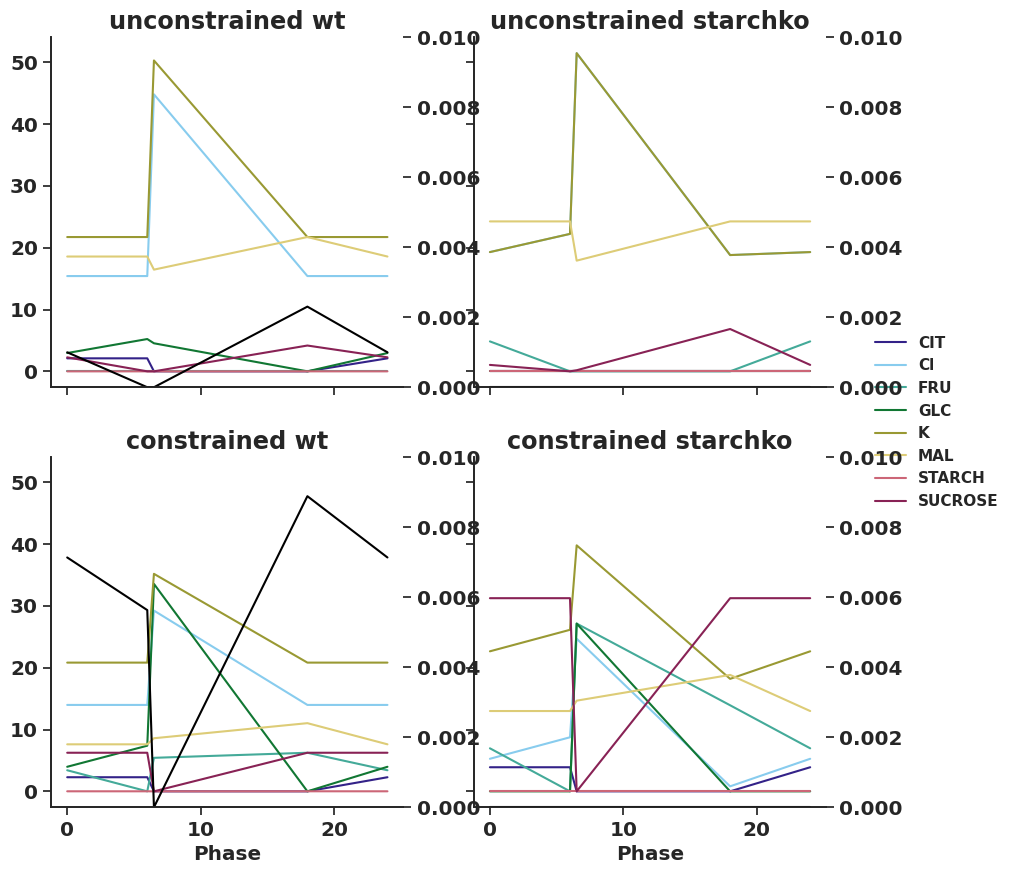

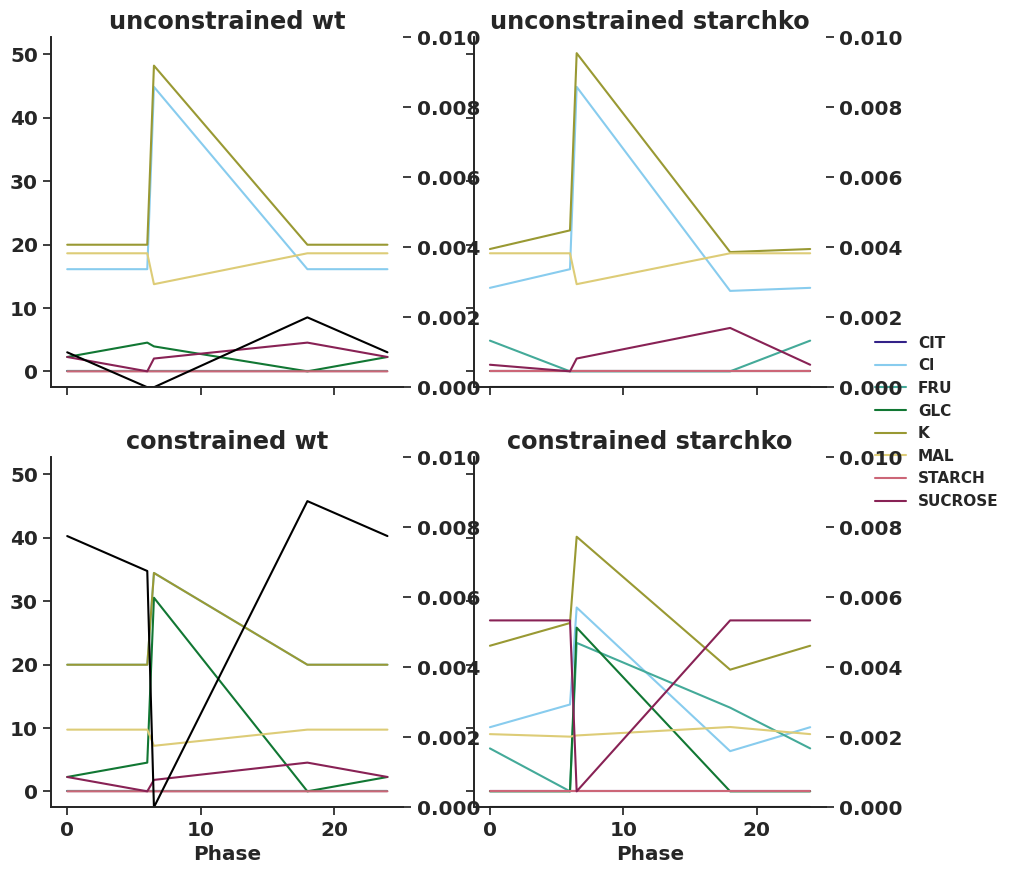

In [26]:
for light in ["blue", "white"]:
    plot_linkers(met_df_mm, light)

## Plotting before and after opening

In [27]:
def convert_starch_cols_to_per_gc(row_series, SuperModel, units):
    if row_series.name[1] == "STARCH":
        n_gcs = SuperModel.N_gcs
        row_series_moles = row_series * 10**-3
        moles_per_gc = row_series_moles / n_gcs
        row_series_converted_to_units = moles_per_gc * (1 / units)

        return row_series_converted_to_units

    else:
        return row_series

In [28]:
femtomoles = 10**-15
met_df_mm_starch_fmol_per_gc = met_df_mm.apply(
    convert_starch_cols_to_per_gc, args=[arabidopsis_supermodel, femtomoles], axis=1
)

In [29]:
met_df_mm_starch_fmol_per_gc.xs("STARCH", level="Reaction").xs("fluxes", level="Solution", axis=1)

Light           blue                                       white           \
ATPase unconstrained          constrained          unconstrained            
Starch            wt starchko          wt starchko            wt starchko   
Phase                                                                       
0.0         1.721263      0.0   12.304542      0.0      1.721263      0.0   
6.0         0.000000      0.0    9.711447      0.0      0.000000      0.0   
6.5         0.000000      0.0    0.000000      0.0      0.000000      0.0   
18.0        3.971787      0.0   15.323291      0.0      3.442527      0.0   
24.0        1.721263      0.0   12.304542      0.0      1.721263      0.0   

Light                                nops                                
ATPase constrained          unconstrained          constrained           
Starch          wt starchko            wt starchko          wt starchko  
Phase                                                                    
0.0      13.359047      0.0           0.0      0.0    5.132157      0.0  
6.0      11.637770      0.0           0.0      0.0    5.132157      0.0  
6.5       0.000000      0.0           0.0      0.0    0.000000      0.0  
18.0     15.080297      0.0           0.0      0.0    5.132157      0.0  
24.0     13.359047      0.0           0.0      0.0    5.132157      0.0

/tmp/ipykernel_1339030/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_1339030/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_1339030/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_1339030/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
/tmp/ipykernel_1339030/3835851778.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specif

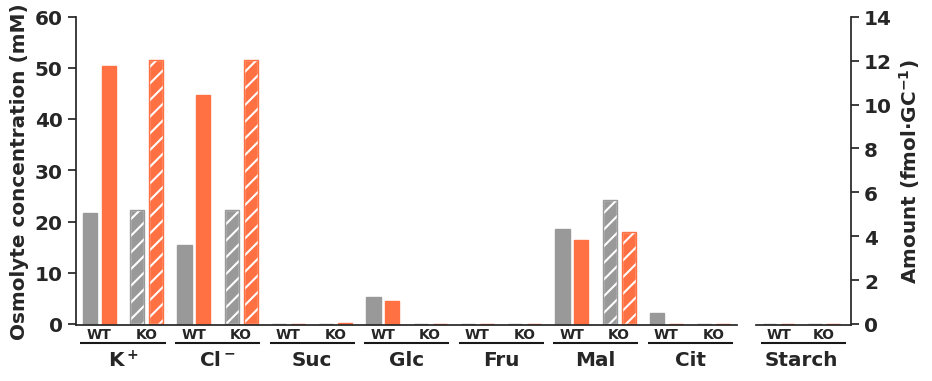

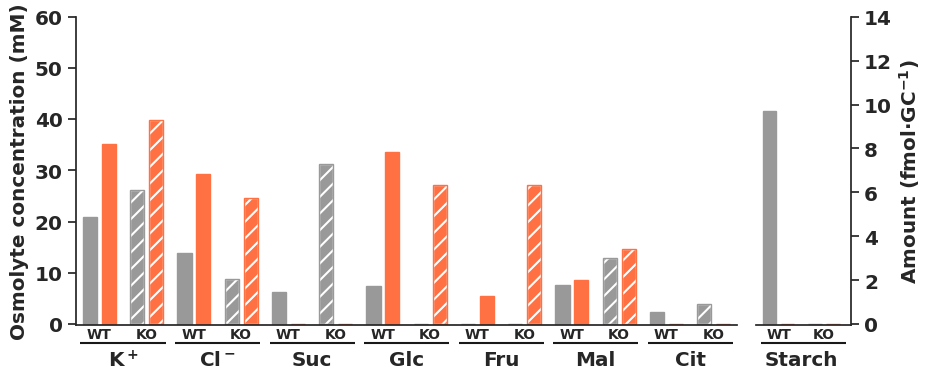

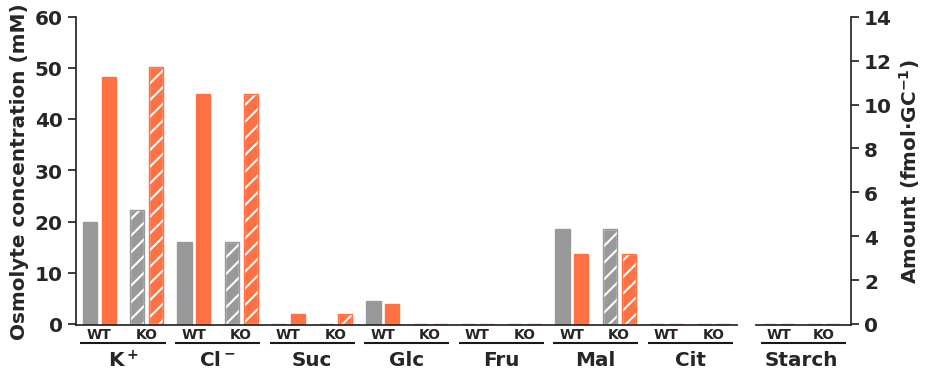

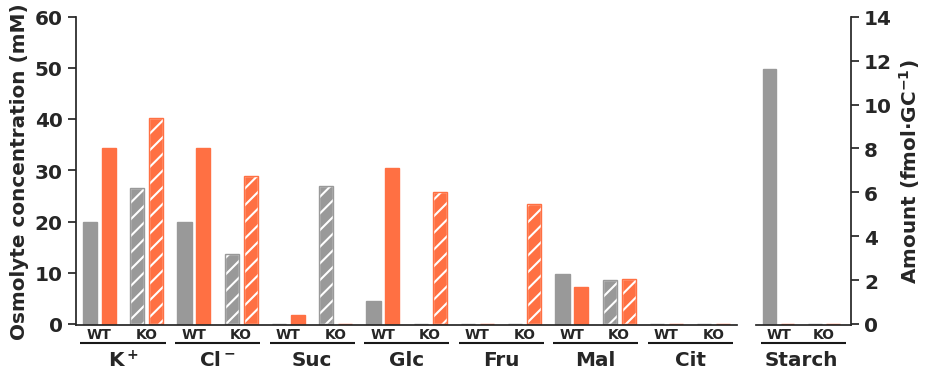

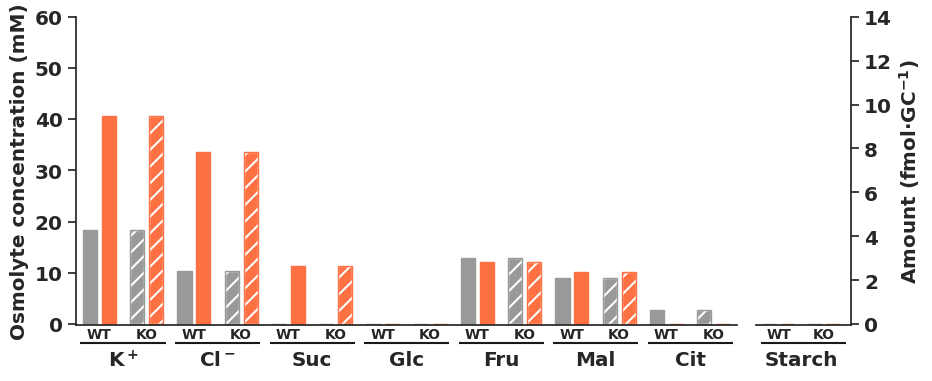

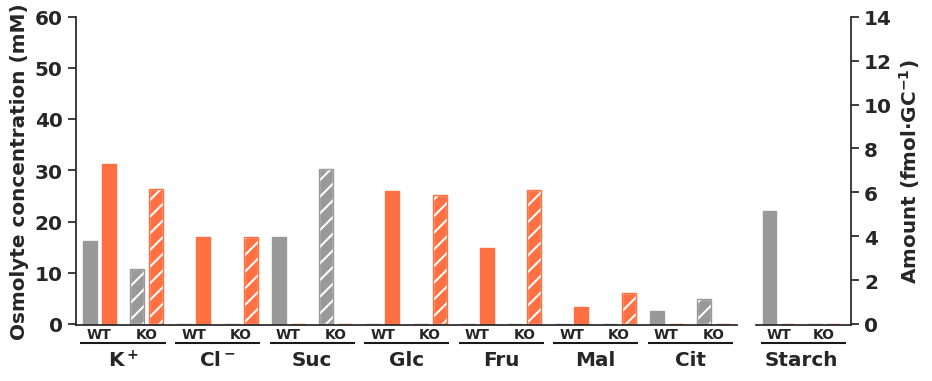

In [30]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs("fluxes", level="Solution", axis=1)
        fig = get_totals_plot(specific_df)
        plot_name = f"{light}_{atpase}"
        fig.savefig(
            f"../outputs/total_opening_plots/{plot_name}.svg",
            format="svg",
            bbox_inches="tight",
        )
        fig.savefig(
            f"../outputs/total_opening_plots/{plot_name}.png",
            format="png",
            bbox_inches="tight",
            dpi=300,
        )

## Flux maps

In [31]:
map_translation = {
    "": "Opening",
    "_1": "Night2",
    "_2": "Night1",
    "_3": "Day",
}

In [32]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        for starch in ["wt", "starchko"]:
            for map_suffix in ["", "_1", "_2", "_3"]:
                model_solution = solutions_df_unphased.loc[:, (light, atpase, starch, "fluxes")]
                flux_map = get_escher_map(
                    model_solution,
                    map=f"../inputs/map{map_suffix}.json",
                    json_model="../models/4_stage_GC.json",
                )
                flux_map_name = f"{light}_{atpase}_{starch}"
                flux_map.save_html(f"../outputs/escher_maps/{flux_map_name}_{map_translation[map_suffix]}.html")

In [33]:
linkers_met_dict = {
    "SUCROSE": "Suc",
    "GLC": "Glc",
    "FRU": "Fru",
    "MAL": "Mal",
    "CIT": "Cit",
    "L_ASPARTATE": "Asp",
    "SER": "Ser",
}

In [34]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("white", "constrained", "starchko", "fluxes"),
].unstack(0)

Phase                          6.0        6.5
Reaction    Compartment                      
SUCROSE     Cytoplasm     0.000000   0.000000
            Vacuole      35.895695   0.000000
GLC         Cytoplasm     0.000000   9.643569
            Vacuole       0.000000  31.177975
FRU         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000  31.177975
MAL         Cytoplasm    34.637290   0.000000
            Vacuole       0.000000   8.214631
CIT         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000   0.000000
L_ASPARTATE Vacuole       0.000000   0.000000
SER         Vacuole       0.000000   0.000000

In [35]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("white", "constrained", "wt", "fluxes"),
].unstack(0)

Phase                          6.0         6.5
Reaction    Compartment                       
SUCROSE     Cytoplasm     0.000000    7.249615
            Vacuole       0.000000    0.000000
GLC         Cytoplasm    18.191328  122.630257
            Vacuole       0.000000    0.000000
FRU         Cytoplasm     0.000000    0.000000
            Vacuole       0.000000    0.000000
MAL         Cytoplasm     0.000000   28.854314
            Vacuole       9.070770    0.000000
CIT         Cytoplasm     0.000000    0.000000
            Vacuole       0.000000    0.000000
L_ASPARTATE Vacuole       0.000000    0.000000
SER         Vacuole       0.000000    0.000000

In [36]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        for starch in ["wt", "starchko"]:
            print(f"{light}_{atpase}_{starch}")

            mets_to_include = [
                "SUCROSE",
                "GLC",
                "FRU",
                "MAL",
                "CIT",
                "L_ASPARTATE",
                "SER",
            ]
            test_df = linkers_df.loc[
                (
                    [6, 6.5],
                    mets_to_include,
                ),
                (light, atpase, starch, "fluxes"),
            ].unstack(0)
            test_df.columns = ["EoN", "30 mins"]
            test_df.index = pd.MultiIndex.from_tuples(
                [(linkers_met_dict[index[0]], index[1]) for index in test_df.index]
            )

            scaling = 0.4

            test_df = test_df * scaling

            if (test_df.loc[["Asp", "Ser"]] > 0.0000000001).sum().sum() > 0:
                aspser = True
                print(test_df)
            else:
                aspser = False

            scale_conc = 50  # mM

            scaled_scale_conc = scale_conc * scaling

            map_name = f"{light}_{atpase}_{starch}"
            if starch == "wt":
                gc_path = getgcdiagram(
                    test_df,
                    map_name,
                    atpase,
                    starch,
                    scaled_scale_conc,
                    flipped=False,
                    aspser=aspser,
                    display_svg=True,
                    debug=False,
                    brokenaxis=False,
                )
            else:
                gc_path = getgcdiagram(
                    test_df,
                    map_name,
                    atpase,
                    starch,
                    scaled_scale_conc,
                    flipped=True,
                    aspser=aspser,
                    display_svg=True,
                    debug=False,
                    brokenaxis=False,
                )

            # doesn't seem to work with hatched
            # svg_code = open(gc_path, 'rt').read()
            # svg2png(bytestring=svg_code, write_to=f"../outputs/flux_maps/{map_name}.png", dpi=300)

blue_unconstrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


blue_unconstrained_starchko
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


blue_constrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


blue_constrained_starchko
                     EoN    30 mins
Suc Cytoplasm   0.000000   0.000000
    Vacuole    16.641421   0.000000
Glc Cytoplasm   0.000000   0.000000
    Vacuole     0.000000  14.454262
Fru Cytoplasm   0.000000   0.000000
    Vacuole     0.000000  14.454262
Mal Cytoplasm   0.000000  23.563777
    Vacuole     4.843435   0.000000
Cit Cytoplasm   6.260619   0.000000
    Vacuole     0.000000   0.000000
Asp Vacuole     0.000000   0.000000
Ser Vacuole    36.109298  31.363504
('Cit', 'Vacuole') not in template


white_unconstrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_unconstrained_starchko
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_constrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_constrained_starchko
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_unconstrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_unconstrained_starchko
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_constrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_constrained_starchko
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


In [37]:
blue_phloem_tx_overall_df = solutions_df.loc["Phloem_tx_overall", "blue"].xs("fluxes", level="Solution", axis=1)
white_phloem_tx_overall_df = solutions_df.loc["Phloem_tx_overall", "white"].xs("fluxes", level="Solution", axis=1)

In [38]:
blue_phloem_tx_overall_df_wt_unconstrained_corrected = blue_phloem_tx_overall_df - blue_phloem_tx_overall_df.iloc[0, 0]
blue_phloem_tx_overall_df_wt_unconstrained_corrected = blue_phloem_tx_overall_df_wt_unconstrained_corrected.mask(
    blue_phloem_tx_overall_df_wt_unconstrained_corrected > -0.0000000001, 0
)
blue_phloem_tx_overall_df_wt_unconstrained_corrected_fmol = (
    blue_phloem_tx_overall_df_wt_unconstrained_corrected / parameters_df.loc["N_gcs", "Value"] * 10**12
)

In [39]:
white_phloem_tx_overall_df_wt_unconstrained_corrected = (
    white_phloem_tx_overall_df - white_phloem_tx_overall_df.iloc[0, 0]
)
white_phloem_tx_overall_df_wt_unconstrained_corrected = white_phloem_tx_overall_df_wt_unconstrained_corrected.mask(
    white_phloem_tx_overall_df_wt_unconstrained_corrected > -0.0000000001, 0
)
white_phloem_tx_overall_df_wt_unconstrained_corrected_fmol = (
    white_phloem_tx_overall_df_wt_unconstrained_corrected / parameters_df.loc["N_gcs", "Value"] * 10**12
)

In [40]:
combined_fmol = pd.concat(
    [
        blue_phloem_tx_overall_df_wt_unconstrained_corrected_fmol,
        white_phloem_tx_overall_df_wt_unconstrained_corrected_fmol,
    ],
    keys=["Blue", "White"],
)
combined_fmol.index = combined_fmol.index.droplevel(1)
combined_fmol

ATPase unconstrained           constrained          
Starch            wt  starchko          wt  starchko
Blue             0.0 -0.000528   -0.010206 -0.021888
White            0.0 -0.000463   -0.012157 -0.028908

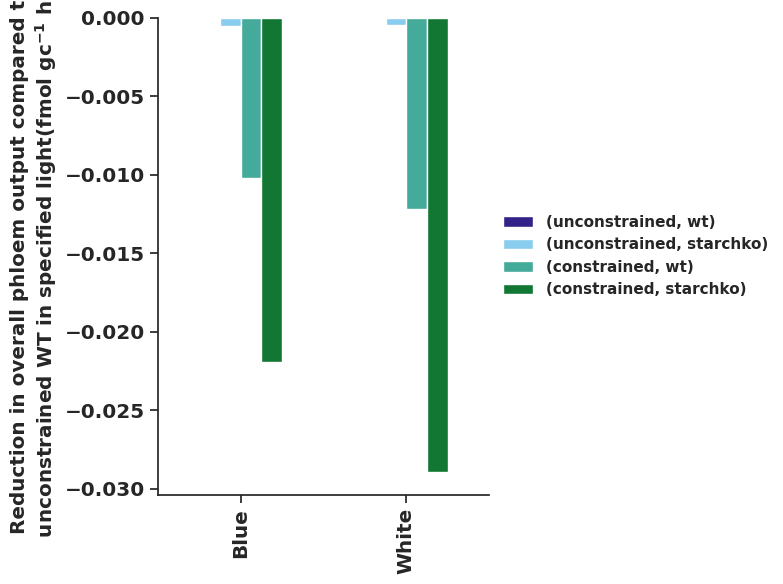

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
combined_fmol.plot.bar(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_ylabel(
    "Reduction in overall phloem output compared to \n unconstrained WT in specified light(fmol gc$^{-1}$ h$^{-1}$)"
)

fig.set_tight_layout(True)

fig.savefig("../outputs/efficiency_comparisons/efficiency_comparisons_compared.svg")
fig.savefig("../outputs/efficiency_comparisons/efficiency_comparisons_compared.png")

In [42]:
from functools import reduce

In [43]:
def multiply_series_by_coefficient(series_object, model, metabolite_id):
    reaction_id = series_object.name[0]
    coefficient = model.reactions.get_by_id(f"{reaction_id}_1").get_coefficient(f"{metabolite_id}_1")
    return coefficient * series_object

In [44]:
def get_metabolite_budget(solution_df, metabolite, model):
    metabolite_reactions_df = solution_df.loc[
        (
            [reaction.id[:-2] for reaction in four_stage_GC_model.metabolites.get_by_id(f"{metabolite}_1").reactions],
            slice(None),
        ),
        :,
    ]
    metabolite_consumed_produced_df = metabolite_reactions_df.apply(
        multiply_series_by_coefficient, args=[model, metabolite], axis=1
    )
    return metabolite_consumed_produced_df

In [45]:
def get_relevant_reaction_fluxes(
    solution_df,
    scenarios_to_drop=[("nops", "unconstrained"), ("white", "unconstrained")],
):
    solution_df = solution_df.xs("fluxes", level="Solution", axis=1)
    solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in
    solution_df = solution_df.loc[
        (abs(solution_df) > 0.00001).any(axis=1), :
    ]  # pick only reactions which have a flux in at least one scenario
    solution_df[abs(solution_df) < 0.00001] = 0  # ignore tiny fluxes from solver error

    return solution_df

In [46]:
def get_budget_for_multiple_metabolites(solution_df, metabolites, fba_model):
    metabolite_dfs = [get_metabolite_budget(solution_df, metabolite, fba_model) for metabolite in metabolites]
    metabolite_total_df = reduce(lambda a, b: a.add(b, fill_value=0), metabolite_dfs)
    metabolite_total_df = get_relevant_reaction_fluxes(metabolite_total_df)

    return metabolite_total_df

In [47]:
atp_metabolites = [metabolite.id for metabolite in four_stage_GC_model.metabolites if "ATP" in metabolite.id]
gc_atp_metabolites = [metabolite[:-2] for metabolite in atp_metabolites if "gc_2" in metabolite]
gc_atp_metabolites = [e for e in gc_atp_metabolites if e not in ("DATP_p_gc", "PHOSPHORIBOSYL_ATP_p_gc", "aDATP_p_gc")]
atp_budget_df = get_budget_for_multiple_metabolites(solutions_df, gc_atp_metabolites, four_stage_GC_model)

/tmp/ipykernel_1339030/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


In [48]:
nadh_nadph_metabolites = [
    metabolite.id
    for metabolite in four_stage_GC_model.metabolites
    if "NADH" in metabolite.id or "NADPH" in metabolite.id
]
gc_nadh_nadph_metabolites = [metabolite[:-2] for metabolite in nadh_nadph_metabolites if "gc_2" in metabolite]
nadh_nadph_budget_df = get_budget_for_multiple_metabolites(solutions_df, gc_nadh_nadph_metabolites, four_stage_GC_model)

/tmp/ipykernel_1339030/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


In [49]:
nadh_nadph_budget_df

Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2          0.000000  0.000000   
                                       3          0.022910  0.022910   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2          0.000000  0.000000   
                                       3         -0.019493 -0.019503   
2OXOGLUTARATEDEH_RXN_m_gc              1          0.000286  0.000298   
...                                                    ...       ...   
NADPHox_p_tx_gc                        4         -0.000426 -0.000426   
PYRUVDEH_RXN_m_gc                      1          0.000286  0.000298   
                                       2          0.000764  0.001246   
                                       3          0.000000  0.000000   
                                       4          0.000324  0.000284   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000   
                                       3        0.022910  0.022910   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000  0.000000   
                                       3       -0.019453 -0.019417   
2OXOGLUTARATEDEH_RXN_m_gc              1        0.000289  0.000301   
...                                                  ...       ...   
NADPHox_p_tx_gc                        4       -0.000425 -0.000421   
PYRUVDEH_RXN_m_gc                      1        0.000289  0.000301   
                                       2        0.000476  0.000000   
                                       3        0.000000  0.000000   
                                       4        0.000329  0.000373   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.022910  0.022910   
                                       3        0.022910  0.022910   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2       -0.018769 -0.017978   
                                       3       -0.019450 -0.019467   
2OXOGLUTARATEDEH_RXN_m_gc              1        0.000286  0.000305   
...                                                  ...       ...   
NADPHox_p_tx_gc                        4       -0.000426 -0.000403   
PYRUVDEH_RXN_m_gc                      1        0.000286  0.000305   
                                       2        0.000000  0.000000   
                                       3        0.000000  0.000000   
                                       4        0.000286  0.000312   

Light                                               nops            
ATPase                                       constrained            
Starch                                                wt  starchko  
Reaction                               Phase                        
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2         0.00000  0.000000  
                                       3         0.00000  0.000000  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2         0.00000  0.000000  
                                       3         0.00000  0.000000  
2OXOGLUTARATEDEH_RXN_m_gc              1         0.00000  0.000313  
...                                                  ...       ...  
NADPHox_p_tx_gc                        4         0.00000 -0.000417  
PYRUVDEH_RXN_m_gc                      1         0.00000  

In [50]:
atp_ordered_by_most_likely_importance = (
    abs(atp_budget_df).groupby(by="Reaction").sum().sum(axis=1).sort_values(ascending=False)
)
atp_budget_df_reordered = atp_budget_df.reindex(atp_ordered_by_most_likely_importance.index, level="Reaction")

In [51]:
nadh_nadph_ordered_by_most_likely_importance = (
    abs(nadh_nadph_budget_df).groupby(by="Reaction").sum().sum(axis=1).sort_values(ascending=False)
)
nadh_nadph_budget_df_reordered = nadh_nadph_budget_df.reindex(
    nadh_nadph_ordered_by_most_likely_importance.index, level="Reaction"
)

In [52]:
def convert_fluxes_to_per_guard_cell(series, super_model, units):
    return series * 10**-3 / super_model.N_gcs * (1 / units)

In [53]:
units = 10**-15  # fmol

In [54]:
atp_budget_df_reordered_nmoles_gc = atp_budget_df_reordered.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)
nadh_nadph_budget_df_reordered_nmoles_gc = nadh_nadph_budget_df_reordered.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)

Carbon movement df generation

In [55]:
apoplastic_linker_reactions = [
    reaction.id[:-2] for reaction in four_stage_GC_model.reactions if "a_Linker" in reaction.id
]
get_relevant_reaction_fluxes(solutions_df.loc[(apoplastic_linker_reactions, slice(None)), :])

/tmp/ipykernel_1339030/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


Light                           blue                                  \
ATPase                 unconstrained           constrained             
Starch                            wt  starchko          wt  starchko   
Reaction         Phase                                                 
SUCROSE_a_Linker 3          0.007141  0.007714    0.003449  0.004237   
                 4          0.000000  0.000000    0.000000  0.000000   

Light                        white                  nops            
ATPase                 constrained           constrained            
Starch                          wt  starchko          wt  starchko  
Reaction         Phase                                              
SUCROSE_a_Linker 3        0.004339  0.004903         0.0  0.003130  
                 4        0.000000  0.000000         0.0  0.001565

In [56]:
transfer_reactions = [reaction.id[:-2] for reaction in four_stage_GC_model.reactions if "ae_gc" in reaction.id]
transfer_reactions = [e for e in transfer_reactions if e not in ("WATER_ae_gc", "K_ae_gc", "Cl_ae_gc", "NITRATE_ae_gc")]
transfer_reactions = solutions_df.loc[(transfer_reactions, slice(None)), :]
transfer_reactions = get_relevant_reaction_fluxes(transfer_reactions)
transfer_reactions.loc[("GLC_ae_gc", 2), :] = 0
transfer_reactions

/tmp/ipykernel_1339030/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_gc 1          0.000000  0.000000     0.00000  0.000000    0.000000   
              3         -0.000621 -0.000671    -0.00030 -0.000368   -0.000377   
              4          0.000000  0.000000     0.00000  0.000000    0.000000   
GLC_ae_gc     3         -0.000100  0.000000    -0.00074 -0.000599   -0.000674   
              2          0.000000  0.000000     0.00000  0.000000    0.000000   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_gc 1      0.000000    0.000000  0.000261  
              3     -0.000426    0.000305  0.000286  
              4      0.000000    0.000000  0.000261  
GLC_ae_gc     3     -0.000570   -0.000574 -0.000558  
              2      0.000000    0.000000  0.000000

In [57]:
transfer_reactions_me = [reaction.id[:-2] for reaction in four_stage_GC_model.reactions if "ae_me" in reaction.id]
transfer_reactions_me = [
    e
    for e in transfer_reactions_me
    if e
    not in (
        "WATER_ae_me",
        "K_ae_me",
        "Cl_ae_me",
        "NITRATE_ae_me",
        "SULFATE_ae_me",
        "AMMONIUM_ae_me",
    )
]
transfer_reactions_me = get_relevant_reaction_fluxes(solutions_df.loc[(transfer_reactions_me, slice(None)), :])
transfer_reactions_me

/tmp/ipykernel_1339030/3164465358.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(scenarios_to_drop, axis=1)  # only keep the scenarios that we are interested in


Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_me 3           0.00000  0.000000    0.000000  0.000000    0.000000   
              4           0.00119  0.001286    0.000575  0.000706    0.000723   
GLC_ae_me     3           0.00010  0.000000    0.000740  0.000599    0.000674   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_me 3      0.000000   -0.000305 -0.000558  
              4      0.000817    0.000000  0.000000  
GLC_ae_me     3      0.000570    0.000574  0.000558

In [58]:
def adjust_for_hexose_equivalents(series_object):
    hexose_equivalents = {
        "GLC": 1,
        "SUCROSE": 2,
        "FRU": 1,
    }

    metabolite = series_object.name[0].split("_")[0]
    hexose_equivalent = hexose_equivalents[metabolite]

    return series_object * hexose_equivalent

In [59]:
from mmon_gcm.analysing import adjust_for_phases

In [60]:
transfer_reactions_me

Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_me 3           0.00000  0.000000    0.000000  0.000000    0.000000   
              4           0.00119  0.001286    0.000575  0.000706    0.000723   
GLC_ae_me     3           0.00010  0.000000    0.000740  0.000599    0.000674   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_me 3      0.000000   -0.000305 -0.000558  
              4      0.000817    0.000000  0.000000  
GLC_ae_me     3      0.000570    0.000574  0.000558

In [61]:
me_carbon_production_consumption = (
    transfer_reactions_me.apply(adjust_for_phases, args=[four_stage_GC_model], axis=1)
    .apply(adjust_for_hexose_equivalents, axis=1)
    .sum()
    * -1
)
me_carbon_production_consumption

Light  ATPase         Starch  
blue   unconstrained  wt         -0.015433
                      starchko   -0.015428
       constrained    wt         -0.015412
                      starchko   -0.015361
white  constrained    wt         -0.016426
                      starchko   -0.016356
nops   constrained    wt          0.000405
                      starchko    0.006417
dtype: float64

In [62]:
gc_carbon_production_consumption = (
    transfer_reactions.loc[["GLC_ae_gc", "SUCROSE_ae_gc"], :]
    .apply(adjust_for_phases, args=[four_stage_GC_model], axis=1)
    .apply(adjust_for_hexose_equivalents, axis=1)
    * -1
)
gc_carbon_production_consumption

Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
GLC_ae_gc     3          0.001152 -0.000000    0.008514  0.006886    0.007748   
              2         -0.000000 -0.000000   -0.000000 -0.000000   -0.000000   
SUCROSE_ae_gc 1         -0.000000 -0.000000   -0.000000 -0.000000   -0.000000   
              3          0.014281  0.015428    0.006898  0.008474    0.008678   
              4         -0.000000 -0.000000   -0.000000 -0.000000   -0.000000   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
GLC_ae_gc     3      0.006551    0.006605  0.006420  
              2     -0.000000   -0.000000 -0.000000  
SUCROSE_ae_gc 1     -0.000000   -0.000000 -0.003130  
              3      0.009805   -0.007010 -0.006577  
              4     -0.000000   -0.000000 -0.003130

In [63]:
gc_carbon_production_consumption_nmoles_gc = gc_carbon_production_consumption.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)

In [64]:
atp_colours = {
    "6PFRUCTPHOS_RXN_c_gc": [6, 6],  # phosphofructokinase glycolysis
    "FRUCTOKINASE_RXN_c_gc": [6, 6],  # fructokinase glycolysis
    "GLUC1PADENYLTRANS_RXN_p_gc": [8, 8],  # glc1p -> adp glc (starch synthesis)
    "GLY3KIN_RXN_p_gc": [6, 6],  # g3p -> glycerate (carbon degradation)
    "Mitochondrial_ATP_Synthase_m_gc": [7, 7],  # mitochondrial atp synthase
    "PEPCARBOXYKIN_RXN_c_gc": [6, 6],  # OAA -> pyruvate (mal deg)
    "PEPDEPHOS_RXN_c_gc": [6, 6],  # PEP -> pyruvate
    "PEPDEPHOS_RXN_p_gc": [6, 6],  # PEP -> pyruvate
    "PHOSGLYPHOS_RXN_c_gc": [2, 6],  # DPG -> G3p (glycolysis)
    "PHOSGLYPHOS_RXN_p_gc": [4, 4],  # DPG -> G3p (glycolysis)
    "PHOSPHORIBULOKINASE_RXN_p_gc": [4, 4],  # calvin cycle
    "PROTONATP_rev_vc_gc": [0, 0],  # tonoplastic proton pump
    "PROTON_ATPase_c_gc": [1, 1],  # plasma membrane proton pump
    "Plastidial_ATP_Synthase_p_gc": [3, 3],  # plastidial atp_synthase
    "SUCCCOASYN_RXN_m_gc": [6, 6],  # TCA cycle
    "UDPKIN_RXN_c_gc": [2, 2],  # atp->utp, sucrose synthesis
    "GLUCOKIN_RXN_c_gc": [9, 9],
    "ATP_ADP_mc_gc": [9, 9],  # ATP shuttle
    "ATPase_tx_gc": [9, 9],  # maintenance
    "PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc": [9, 9],
    "ADENYL_KIN_RXN_m_gc": [9, 9],
    "6PFRUCTPHOS_RXN_p_gc": [9, 9],
}

nadh_nadph_colours = {
    "1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc": [3, 3],  # ps
    "1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc": [4, 4],  # ps
    "2OXOGLUTARATEDEH_RXN_m_gc": [6, 6],  # tca
    "GAPOXNPHOSPHN_RXN_c_gc": [2, 6],  # glycolysis or gluconeogenesis
    "GAPOXNPHOSPHN_RXN_p_gc": [4, 4],  # calvin cycle but nadh
    "HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc": [
        5,
        5,
    ],  # OH_PYR_x -> Glycerate_x to do with serine/aspartate metabolism
    "ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc": [6, 6],  # tca
    "MALATE_DEHYDROGENASE_NADPs_RXN_p_gc": [9, 9],  # shuttle
    "MALATE_DEH_RXN_c_gc": [
        9,
        6,
    ],  # malate degradation when forward but also shuttle in reverse
    "MALATE_DEH_RXN_m_gc": [9, 9],  # can be tca but mainly shuttle
    "MALATE_DEH_RXN_p_gc": [9, 9],  # shuttle
    "MALATE_DEH_RXN_x_gc": [9, 9],  # shuttle
    "MALIC_NAD_RXN_m_gc": [6, 6],  # malate degradation (al->pyr)
    "NADH_DEHYDROG_A_RXN_mi_gc": [7, 7],  # complex 1 (TC)
    "PGLYCDEHYDROG_RXN_p_gc": [5, 5],  # ser_synthesis from g3p
    "PYRUVDEH_RXN_m_gc": [6, 6],  # pyruvate degradation
    "ISOCITDEH_RXN_c_gc": [6, 6],  # tca nadp
    "6PGLUCONDEHYDROG_RXN_p_gc": [9, 9],  # PPP
    "NADPHox_c_tx_gc": [9, 9],
    "NADPHox_p_tx_gc": [9, 9],
    "GLU6PDEHYDROG_RXN_c_gc": [9, 9],
    "6PGLUCONDEHYDROG_RXN_c_gc": [9, 9],
    "GLU6PDEHYDROG_RXN_p_gc": [9, 9],
    "MALIC_NADP_RXN_c_gc": [9, 9],
}

reaction_colours = {**atp_colours, **nadh_nadph_colours}
for reaction, colour_number in reaction_colours.items():
    for i, reverse_forward in enumerate(colour_number):
        if reverse_forward == 9:
            reaction_colours[reaction][i] = "#DDDDDD"
        else:
            reaction_colours[reaction][i] = colours[reverse_forward]

In [65]:
colours_legend = {
    "Tonoplast membrane ATPase": 0,
    "Plasma membrane ATPase": 1,
    "Sucrose/Glucose synthesis": 2,
    "Plastid/PS": 3,
    "Carbon fixation": 4,
    "Serine Synthesis": 5,
    "Carbon degradation\n(Glycolysis, TCA etc.)": 6,
    "ETC/Mitochondrial\nATP Synthase": 7,
    "Starch synthesis": 8,
    "Other e.g. shuttles, maintenance": 9,
}
for category, colour_number in colours_legend.items():
    if colour_number == 9:
        colours_legend[category] = "#DDDDDD"
    else:
        colours_legend[category] = colours[colour_number]

In [66]:
carbon_colours = {
    "SUCROSE_ae_gc": colours[2],
    "GLC_ae_gc": colours[6],
    "FRU_ae_gc": colours[4],
}

In [67]:
legend_colours = {
    "Glucose": colours[6],
    "Sucrose": colours[2],
}

In [68]:
nadh_nadph_budget_df_reordered_nmoles_gc

Light                                                 blue             \
ATPase                                       unconstrained              
Starch                                                  wt   starchko   
Reaction                               Phase                            
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2          0.000000   0.000000   
                                       3         39.500551  39.500551   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2          0.000000   0.000000   
                                       3        -33.608637 -33.626248   
NADH_DEHYDROG_A_RXN_mi_gc              1         -1.974610  -2.054135   
...                                                    ...        ...   
MALIC_NADP_RXN_c_gc                    2          1.317701   2.148741   
                                       3          0.000000   0.000000   
                                       4          0.066618   0.000000   
MALATE_DEH_RXN_p_gc                    3          0.000000   0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3          0.000000   0.000000   

Light                                                                \
ATPase                                       constrained              
Starch                                                wt   starchko   
Reaction                               Phase                          
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000   0.000000   
                                       3       39.500551  39.500551   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000   0.000000   
                                       3      -33.539357 -33.477663   
NADH_DEHYDROG_A_RXN_mi_gc              1       -1.992530  -2.075135   
...                                                  ...        ...   
MALIC_NADP_RXN_c_gc                    2        0.000000   0.000000   
                                       3        0.000000   0.000000   
                                       4        0.072259   0.123412   
MALATE_DEH_RXN_p_gc                    3        0.000000   0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000   0.000000   

Light                                              white             \
ATPase                                       constrained              
Starch                                                wt   starchko   
Reaction                               Phase                          
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2       39.500551  39.500551   
                                       3       39.500551  39.500551   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2      -32.361199 -30.996731   
                                       3      -33.534048 -33.563204   
NADH_DEHYDROG_A_RXN_mi_gc              1       -1.974610  -2.076293   
...                                                  ...        ...   
MALIC_NADP_RXN_c_gc                    2        0.000000   0.000000   
                                       3        0.000000   0.000000   
                                       4        0.000000   0.071169   
MALATE_DEH_RXN_p_gc                    3        0.000000   0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000   0.000000   

Light                                               nops            
ATPase                                       constrained            
Starch                                                wt  starchko  
Reaction                               Phase                        
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000  
                                       3        0.000000  0.000000  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000  0.000000  
                                       3        0.000000  0.000000  
NADH_DEHYDROG_A_RXN_mi_gc              1        0.000000 -2.161095  
...                                                  ...       ...  
MALIC_NADP_RXN_c_gc                    2        0.000000  0.000000  
             

In [69]:
color_order = [
    [nadh_nadph_colours[reaction][1], reaction] for reaction in nadh_nadph_budget_df_reordered_nmoles_gc.index.levels[0]
]
nadh_nadph_budget_df_reordered_nmoles_gc = nadh_nadph_budget_df_reordered_nmoles_gc.loc[
    pd.DataFrame(color_order).sort_values(by=[0, 1]).loc[:, 1].values
]

In [70]:
color_order = [[atp_colours[reaction][1], reaction] for reaction in atp_budget_df_reordered_nmoles_gc.index.levels[0]]
atp_budget_df_reordered_nmoles_gc = atp_budget_df_reordered_nmoles_gc.loc[
    pd.DataFrame(color_order).sort_values(by=[0, 1]).loc[:, 1].values
]

In [71]:
atp_budget_df_reordered_nmoles_gc.drop("nops", axis=1).loc[("Plastidial_ATP_Synthase_p_gc", 3)].mean()

/tmp/ipykernel_1339030/544428024.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  atp_budget_df_reordered_nmoles_gc.drop("nops", axis=1).loc[("Plastidial_ATP_Synthase_p_gc", 3)].mean()


50.78642316655137

In [72]:
(abs(nadh_nadph_budget_df_reordered_nmoles_gc) / 2).sum()

Light  ATPase         Starch  
blue   unconstrained  wt          62.774198
                      starchko    64.325199
       constrained    wt          61.689659
                      starchko    59.391591
white  constrained    wt          98.104654
                      starchko    97.406624
nops   constrained    wt           5.366958
                      starchko    25.352772
dtype: float64

In [73]:
nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), :]

Light                                                 blue             \
ATPase                                       unconstrained              
Starch                                                  wt   starchko   
Reaction                               Phase                            
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3         39.500551  39.500551   
NADH_DEHYDROG_A_RXN_mi_gc              3         -3.104337  -3.058563   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        -33.608637 -33.626248   
GAPOXNPHOSPHN_RXN_p_gc                 3          0.000000   0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3          0.000000   0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3          0.000000   0.000000   
ISOCITDEH_RXN_c_gc                     3          0.000000   0.000000   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3          0.000000   0.000000   
MALATE_DEH_RXN_c_gc                    3          0.000000   0.000000   
PYRUVDEH_RXN_m_gc                      3          0.000000   0.000000   
6PGLUCONDEHYDROG_RXN_c_gc              3          0.000000   0.000000   
6PGLUCONDEHYDROG_RXN_p_gc              3          0.000000   0.000000   
GLU6PDEHYDROG_RXN_c_gc                 3          0.000000   0.000000   
GLU6PDEHYDROG_RXN_p_gc                 3          0.000000   0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3         -3.196386  -3.178775   
MALATE_DEH_RXN_m_gc                    3          3.104337   3.058563   
MALATE_DEH_RXN_p_gc                    3          0.000000   0.000000   
MALIC_NADP_RXN_c_gc                    3          0.000000   0.000000   
NADPHox_c_tx_gc                        3          0.000000   0.000000   
NADPHox_p_tx_gc                        3         -2.695528  -2.695528   

Light                                                                \
ATPase                                       constrained              
Starch                                                wt   starchko   
Reaction                               Phase                          
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3       39.500551  39.500551   
NADH_DEHYDROG_A_RXN_mi_gc              3       -3.227966  -3.262971   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3      -33.539357 -33.477663   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000   0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.000000   0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.000000   0.000000   
ISOCITDEH_RXN_c_gc                     3        0.000000   0.000000   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3        0.000000   0.000000   
MALATE_DEH_RXN_c_gc                    3        0.000000   0.000000   
PYRUVDEH_RXN_m_gc                      3        0.000000   0.000000   
6PGLUCONDEHYDROG_RXN_c_gc              3        0.000000   0.000000   
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000000   0.000000   
GLU6PDEHYDROG_RXN_c_gc                 3        0.000000   0.000000   
GLU6PDEHYDROG_RXN_p_gc                 3        0.000000   0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3       -3.265666  -3.327360   
MALATE_DEH_RXN_m_gc                    3        3.227966   3.262971   
MALATE_DEH_RXN_p_gc                    3        0.000000   0.000000   
MALIC_NADP_RXN_c_gc                    3        0.000000   0.000000   
NADPHox_c_tx_gc                        3        0.000000   0.000000   
NADPHox_p_tx_gc                        3       -2.695528  -2.695528   

Light                                              white             \
ATPase                                       constrained              
Starch                                                wt   starchko   
Reaction                               Phase                          
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3       39.500551  39.500551   
NADH_DEHYDROG_A_RXN_mi_gc              3       -3.222740  -3.241819   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3      -33.534048 -33.563204   
GAPOXNPHOSPHN_RXN_p_gc                 3     

In [74]:
nops_nadph_3 = nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), "nops"].index

In [75]:
colours_legend_iv = {v: k for k, v in colours_legend.items()}

In [76]:
nops_nadph_3_df = nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), "nops"]

In [77]:
nops_nadph_3

MultiIndex([('1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc', 3),
            (             'NADH_DEHYDROG_A_RXN_mi_gc', 3),
            ('1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc', 3),
            (                'GAPOXNPHOSPHN_RXN_p_gc', 3),
            (             '2OXOGLUTARATEDEH_RXN_m_gc', 3),
            (                'GAPOXNPHOSPHN_RXN_c_gc', 3),
            (                    'ISOCITDEH_RXN_c_gc', 3),
            ( 'ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc', 3),
            (                   'MALATE_DEH_RXN_c_gc', 3),
            (                     'PYRUVDEH_RXN_m_gc', 3),
            (             '6PGLUCONDEHYDROG_RXN_c_gc', 3),
            (             '6PGLUCONDEHYDROG_RXN_p_gc', 3),
            (                'GLU6PDEHYDROG_RXN_c_gc', 3),
            (                'GLU6PDEHYDROG_RXN_p_gc', 3),
            (   'MALATE_DEHYDROGENASE_NADPs_RXN_p_gc', 3),
            (                   'MALATE_DEH_RXN_m_gc', 3),
            (                   'MALATE_DEH_RXN_p_gc', 3

In [78]:
nops_nadph_3_reactions = [i[0] for i in nops_nadph_3]

In [79]:
descriptions = []
for reaction in nops_nadph_3_reactions:
    descriptions.append(colours_legend_iv[nadh_nadph_colours[reaction][0]].replace("\n", ""))

In [80]:
nops_nadph_3_df.loc[:, "Description"] = descriptions

In [81]:
nops_nadph_3_df

ATPase                                       constrained            \
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.000000  0.000000   
NADH_DEHYDROG_A_RXN_mi_gc              3       -0.438120 -2.269173   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.000000  0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.039595  0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.037019  0.463594   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.039595  0.555272   
ISOCITDEH_RXN_c_gc                     3        0.000000  0.463594   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3        0.037019  0.000000   
MALATE_DEH_RXN_c_gc                    3       -0.039595 -0.555272   
PYRUVDEH_RXN_m_gc                      3        0.121361  0.625153   
6PGLUCONDEHYDROG_RXN_c_gc              3        0.000000  0.720684   
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000000  0.360342   
GLU6PDEHYDROG_RXN_c_gc                 3        0.000000  0.720684   
GLU6PDEHYDROG_RXN_p_gc                 3        0.000000  0.360342   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.000000  0.000000   
MALATE_DEH_RXN_m_gc                    3        0.242721  1.180426   
MALATE_DEH_RXN_p_gc                    3       -0.039595  0.000000   
MALIC_NADP_RXN_c_gc                    3        0.000000  0.069881   
NADPHox_c_tx_gc                        3        0.000000 -1.974844   
NADPHox_p_tx_gc                        3        0.000000 -0.720684   

ATPase                                                                     Description  
Starch                                                                                  
Reaction                               Phase                                            
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3                                    Plastid/PS  
NADH_DEHYDROG_A_RXN_mi_gc              3                 ETC/MitochondrialATP Synthase  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3                               Carbon fixation  
GAPOXNPHOSPHN_RXN_p_gc                 3                               Carbon fixation  
2OXOGLUTARATEDEH_RXN_m_gc              3      Carbon degradation(Glycolysis, TCA etc.)  
GAPOXNPHOSPHN_RXN_c_gc                 3                     Sucrose/Glucose synthesis  
ISOCITDEH_RXN_c_gc                     3      Carbon degradation(Glycolysis, TCA etc.)  
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3      Carbon degradation(Glycolysis, TCA etc.)  
MALATE_DEH_RXN_c_gc                    3              Other e.g. shuttles, maintenance  
PYRUVDEH_RXN_m_gc                      3      Carbon degradation(Glycolysis, TCA etc.)  
6PGLUCONDEHYDROG_RXN_c_gc              3              Other e.g. shuttles, maintenance  
6PGLUCONDEHYDROG_RXN_p_gc              3              Other e.g. shuttles, maintenance  
GLU6PDEHYDROG_RXN_c_gc                 3              Other e.g. shuttles, maintenance  
GLU6PDEHYDROG_RXN_p_gc                 3              Other e.g. shuttles, maintenance  
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3              Other e.g. shuttles, maintenance  
MALATE_DEH_RXN_m_gc                    3              Other e.g. shuttles, maintenance  
MALATE_DEH_RXN_p_gc                    3              Other e.g. shuttles, maintenance  
MALIC_NADP_RXN_c_gc                    3              Other e.g. shuttles, maintenance  
NADPHox_c_tx_gc                        3              Other e.g. shuttles, maintenance  
NADPHox_p_tx_gc                        3              Other e.g. shuttles, maintenance

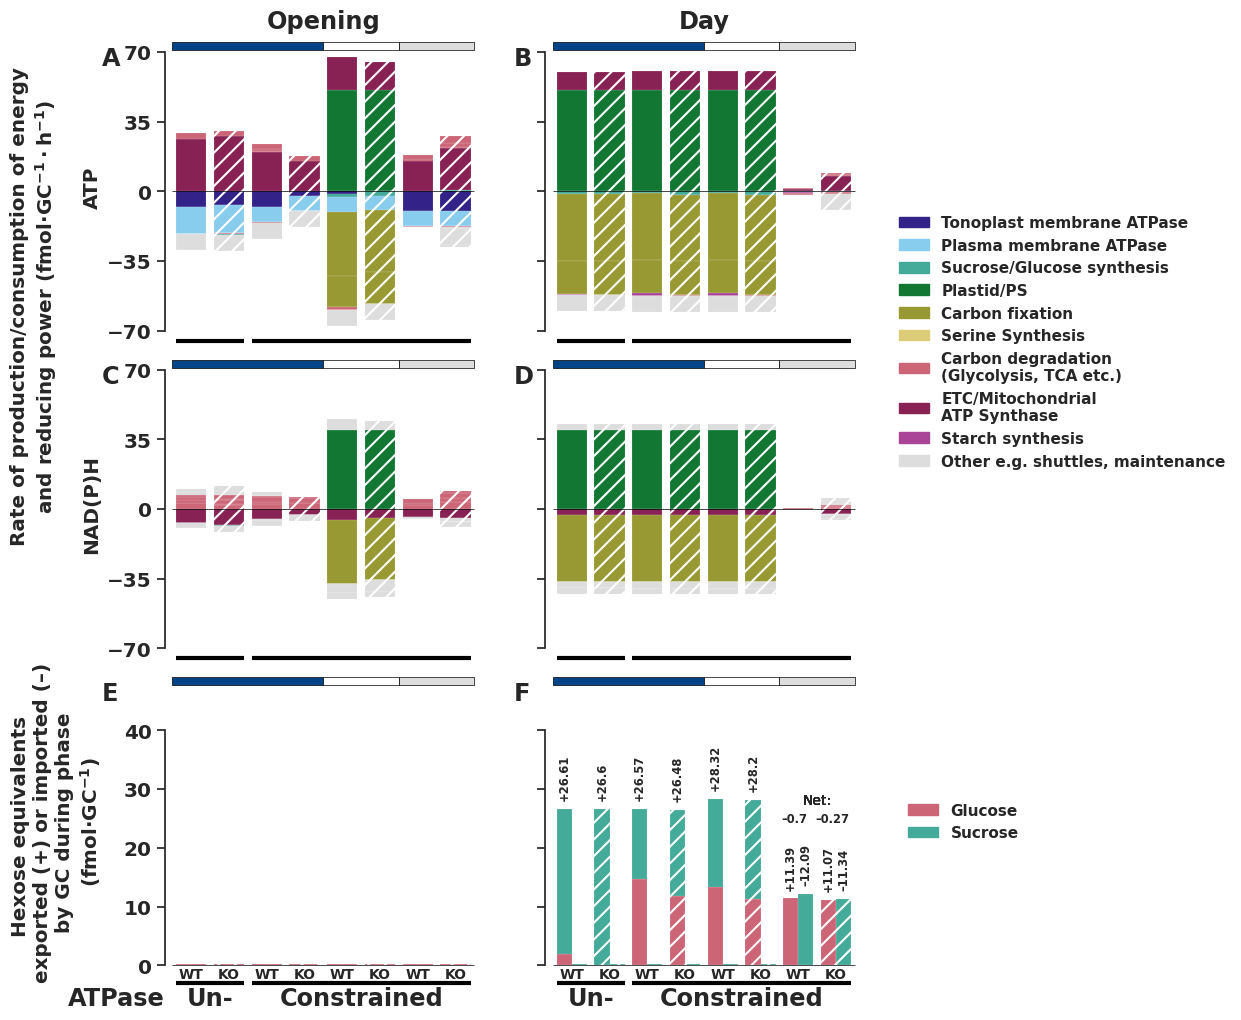

In [82]:
metabolites = ["ATP", "NAD(P)H"]
phases = ["Opening", "Day"]
hatches = {"wt": None, "starchko": "//"}
atpase_labelling = {"unconstrained": "–", "constrained": "+"}

fig, axs = plt.subplots(3, 2, figsize=(9, 12), sharex=True, sharey="row")
plt.subplots_adjust(hspace=0.1)

colour_rectangles_thickness = 4 / (75 * 2)

for y, metabolite in enumerate([atp_budget_df_reordered_nmoles_gc, nadh_nadph_budget_df_reordered_nmoles_gc]):
    for x, phase in enumerate([2, 3]):
        budget_df = metabolite.xs(phase, level="Phase")
        ax = axs[y][x]

        # if y == 0:
        for x1, x2, colour in zip([-0.5, 3.5, 5.5], [3.5, 5.5, 7.5], ["#004488", "white", "#DDDDDD"]):
            ax.fill_betweenx(
                [75 - colour_rectangles_thickness * 75 * 2, 75],
                x1,
                x2,
                alpha=1,
                color=colour,
                linewidth=0.5,
                edgecolor="black",
            )

        for i, scenario in enumerate(budget_df.columns):
            positive_bottom = 0
            negative_top = 0
            scenario_df = budget_df.loc[:, scenario]
            for reaction in scenario_df.index:
                value = scenario_df.loc[reaction]
                if value > 0.00001:
                    ax.bar(
                        i,
                        value,
                        bottom=positive_bottom,
                        color=reaction_colours[reaction][1],
                        linewidth=0.1,
                        hatch=hatches[scenario[2]],
                    )
                    positive_bottom += value
                elif value < 0.00001:
                    ax.bar(
                        i,
                        value,
                        bottom=negative_top,
                        color=reaction_colours[reaction][0],
                        linewidth=0.1,
                        hatch=hatches[scenario[2]],
                    )
                    negative_top += value

        # ax.text(i, positive_bottom + 0.005, round(positive_bottom, 6), rotation=90)
        ax.set_xticks([])  # range(len(budget_df.columns)))
        ax.set_xticklabels([])  # [atpase_labelling[scenario[1]] for scenario in budget_df.columns])

        # if y==1:
        for x1, x2 in zip([-0.4, 1.6], [1.4, 7.4]):  # lines above atpase text
            ax.hlines(-75, x1, x2, color="black", linewidth=3, clip_on=False)

        """    
        atpase_text_y = -80
        if y==1:
            ax.text(0.5, atpase_text_y, "Un-", ha="center", va="top", size="x-large")
            ax.text(4.5, atpase_text_y, "Constrained", ha="center", va="top", size="x-large")
            if x == 0:
                ax.text(-0.7, atpase_text_y, "ATPase", ha="right", va="top", size="x-large")
        """

        if y == 0:
            ax.set_title(phases[x], pad=10)
        if x == 0:
            ax.set_ylabel(metabolites[y])

        ax.set_xlim(-0.70, 7.7)
        ax.set_ylim(-70, 75)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_bounds(-70, 70)
        # ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(35))
        # ax.yaxis.set_minor_locator(AutoMinorLocator(2))

        ax.hlines(0, -0.5, 7.5, color="black", linewidth=0.5)

fig.text(
    -0.02,
    0.66,
    r"Rate of production/consumption of energy" "\n" "and reducing power (fmol$\cdot$GC$^{-1}\cdot$h$^{-1}$)",
    rotation=90,
    va="center",
    ha="center",
    size="large",
)
# ax.set_title(f"ATP Phase {phase}", pad=70)

patchList = []
for key in colours_legend:
    data_key = mpatches.Patch(color=colours_legend[key], label=key)
    patchList.append(data_key)

fig.legend(handles=patchList, loc="center left", bbox_to_anchor=(0.925, 0.63))


for x, ax in enumerate(axs[2]):
    phase = [2, 3][x]

    y_lim_for_hexose = 49

    for x1, x2, colour in zip([-0.5, 3.5, 5.5], [3.5, 5.5, 7.5], ["#004488", "white", "#DDDDDD"]):
        ax.fill_betweenx(
            [
                y_lim_for_hexose - y_lim_for_hexose * colour_rectangles_thickness,
                y_lim_for_hexose,
            ],
            x1,
            x2,
            alpha=1,
            color=colour,
            linewidth=0.5,
            edgecolor="black",
        )

    for i, scenario in enumerate(gc_carbon_production_consumption_nmoles_gc.columns):
        positive_bottom = 0
        negative_top = 0
        scenario_df = gc_carbon_production_consumption_nmoles_gc.xs(phase, level="Phase").loc[:, scenario]
        for reaction in scenario_df.index:
            value = scenario_df.loc[reaction]
            if value > 0.00001:
                ax.bar(
                    i,
                    value,
                    bottom=positive_bottom,
                    color=carbon_colours[reaction],
                    linewidth=0.1,
                    hatch=hatches[scenario[2]],
                    align="edge",
                    width=-0.4,
                )
                positive_bottom += value
            elif value < 0.00001:
                ax.bar(
                    i,
                    abs(value),
                    bottom=negative_top,
                    color=carbon_colours[reaction],
                    linewidth=0.1,
                    hatch=hatches[scenario[2]],
                    align="edge",
                    width=0.4,
                )
                negative_top += abs(value)
        if positive_bottom == 0:
            ax.bar(
                i,
                0.3,
                bottom=0,
                color=carbon_colours[reaction],
                linewidth=0.1,
                hatch=hatches[scenario[2]],
                align="edge",
                width=-0.4,
            )
        if negative_top == 0:
            ax.bar(
                i,
                0.3,
                bottom=0,
                color=carbon_colours[reaction],
                linewidth=0.1,
                hatch=hatches[scenario[2]],
                align="edge",
                width=0.4,
            )

        # ax.text(
        #    i - 0.2, positive_bottom + 1.5, "+", ha="center", va="center", size="large"
        # )
        if positive_bottom > 0:
            ax.text(
                i - 0.2,
                positive_bottom + 1.5,
                f"+{round(positive_bottom, 2)}",
                ha="center",
                va="bottom",
                size="x-small",
                rotation=90,
            )
        # ax.text(i + 0.2, negative_top + 1.5, "-", ha="center", va="center", size="large")
        if negative_top > 0:
            ax.text(
                i + 0.2,
                negative_top + 1.5,
                f"–{abs(round(negative_top, 2))}",
                ha="center",
                va="bottom",
                size="x-small",
                rotation=90,
            )
        if positive_bottom > 0 and negative_top > 0:
            net_value = round(positive_bottom - negative_top, 2)
            if net_value < 0:
                ax.text(
                    i - 0.1,
                    25,
                    f"–{abs(net_value)}",
                    ha="center",
                    va="center",
                    size="x-small",
                )
            else:
                ax.text(
                    i - 0.1,
                    25,
                    f"{net_value}",
                    ha="center",
                    va="center",
                    size="x-small",
                )
        if phase == 3:
            ax.text(6.5, 27, "Net:", ha="center", va="bottom", size="small", weight="normal")

        starch_condition = {"wt": "WT", "starchko": "KO"}[scenario_df.name[2]]
        ax.text(i, -1.5, starch_condition, ha="center", va="center", size="small")

    # ax.hlines(0, -0.5, 7.5, color="black", linewidth=0.5)

    patchList = []
    for key in legend_colours:
        data_key = mpatches.Patch(color=legend_colours[key], label=key)
        patchList.append(data_key)

    if x == 1:
        ax.legend(handles=patchList, loc="center left", bbox_to_anchor=(1.1, 0.5))

    for x1, x2 in zip([-0.4, 1.6], [1.4, 7.4]):  # lines above atpase text
        ax.hlines(-3, x1, x2, color="black", linewidth=3, clip_on=False)

    atpase_text_y = -3.5
    ax.text(0.5, atpase_text_y, "Un-", ha="center", va="top", size="x-large")
    ax.text(4.5, atpase_text_y, "Constrained", ha="center", va="top", size="x-large")
    if x == 0:
        ax.text(-0.7, atpase_text_y, "ATPase", ha="right", va="top", size="x-large")

    ax.set_xlim(-0.7, 7.7)
    ax.set_ylim(-0.1, y_lim_for_hexose)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_bounds(0, 40)
    ax.set_xticks([])  # range(len(budget_df.columns)))
    ax.set_xticklabels([])  # [atpase_labelling[scenario[1]] for scenario in budget_df.columns])

    ax.hlines(0, -0.5, 7.5, color="black", linewidth=0.5)

    if x == 0:
        ax.set_ylabel(
            "Hexose equivalents \n exported (+) or imported (–) \n by GC during phase \n" r"(fmol$\cdot$GC$^{-1}$)",
            labelpad=15,
        )

i = 0
for y in range(3):
    for x in range(2):
        ax = axs[y][x]
        letter = string.ascii_uppercase[i]
        if x == 0:
            ax.text(-0.2, 0.92, letter, size="x-large", transform=ax.transAxes)
        elif x == 1:
            ax.text(-0.1, 0.92, letter, size="x-large", transform=ax.transAxes)
        i += 1


# fig.text(-0.02,0.25, "Hexose equivalents imported (+) \n or exported (-) by GC " r"(nmoles$\cdot$GC$^{-1}$)", rotation=90, va="center", ha="center", size="large")

fig.savefig(f"../plant_cell_paper/figure_6.svg", bbox_inches="tight")
fig.savefig(f"../plant_cell_paper/figure_6.png", dpi=300, bbox_inches="tight")

In [83]:
carbon_rank = gc_carbon_production_consumption_nmoles_gc.sum().rank(ascending=False)

In [84]:
atp_2_rank = abs(atp_budget_df_reordered_nmoles_gc).xs(2, level="Phase").sum().rank(ascending=False)
atp_3_rank = abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase").sum().rank(ascending=False)
atp_rank = (
    (
        abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 0.5
        + abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 11.5
    )
    .sum()
    .rank(ascending=False)
)

In [85]:
nad_2_rank = abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(2, level="Phase").sum().rank(ascending=False)
nad_3_rank = abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase").sum().rank(ascending=False)
nad_rank = (
    (
        abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 0.5
        + abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 11.5
    )
    .sum()
    .rank(ascending=False)
)

In [86]:
pd.concat(
    [carbon_rank, atp_2_rank, atp_3_rank, atp_rank, nad_2_rank, nad_3_rank, nad_rank],
    axis=1,
    keys=["Carbon", "ATP 2", "ATP 3", "ATP Day", "NAD 2", "NAD 3", "NAD Day"],
).sort_values("Carbon")

Carbon  ATP 2  ATP 3  ATP Day  NAD 2  NAD 3  \
Light ATPase        Starch                                                  
white constrained   wt           1.0    1.0    4.0      4.0    1.0    4.0   
                    starchko     2.0    2.0    2.0      2.0    2.0    2.0   
blue  unconstrained wt           3.0    4.0    5.0      5.0    4.0    5.0   
                    starchko     4.0    3.0    6.0      6.0    3.0    6.0   
      constrained   wt           5.0    6.0    3.0      3.0    6.0    3.0   
                    starchko     6.0    8.0    1.0      1.0    7.0    1.0   
nops  constrained   wt           7.0    7.0    8.0      8.0    8.0    8.0   
                    starchko     8.0    5.0    7.0      7.0    5.0    7.0   

                              NAD Day  
Light ATPase        Starch             
white constrained   wt            4.0  
                    starchko      2.0  
blue  unconstrained wt            5.0  
                    starchko      6.0  
      constrained   wt            3.0  
                    starchko      1.0  
nops  constrained   wt            8.0  
                    starchko      7.0

- Starch KO leads to lower carbon consumption and higher ATP and NAD turnover
- Constraining ATPase leads to lower efficiency and higher ATP and NAD turnover
- PS is more complicated because it's both phases, so won't include
    - Removing it vs blue eads to 

## Bits and bobs for paper

In [87]:
blue_constrained_wt_osmolytes = met_df_mm.loc[:, ("blue", "constrained", "wt", "fluxes")].unstack()
os_fraction = (
    (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0])
    / (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]).sum()
    * 100
)
os_fraction

Reaction
CIT        -4.252263
Cl         28.437327
FRU        10.105001
GLC        48.763259
K          26.760721
MAL         1.830498
STARCH     -0.010496
SUCROSE   -11.634047
dtype: float64

In [88]:
blue_constrained_wt_osmolytes

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
0.0,2.281855,13.977664,3.411968,3.972038,20.823229,7.606184,0.007137,6.243078
6.0,2.281855,13.977664,0.000000,7.384006,20.823229,7.606184,0.005633,6.243078
6.5,0.000000,29.237742,5.422560,33.551414,35.183605,8.588469,0.000000,0.000000
18.0,0.000000,13.977664,6.243078,0.000000,20.823229,11.028967,0.008888,6.243078
24.0,2.281855,13.977664,3.411968,3.972038,20.823229,7.606184,0.007137,6.243078


In [89]:
os_fraction.loc["Cl"] + os_fraction.loc["K"]

55.198048458630645

In [90]:
(blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]).loc["Cl"] + (
    blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]
).loc["K"]

29.62045406797854

In [91]:
solutions_df

Light                                 blue                                    \
ATPase                       unconstrained                                     
Starch                                  wt                  starchko           
Solution                            fluxes minimum maximum    fluxes minimum   
Reaction               Phase                                                   
EX_X_pi_t_me           1          0.000000     NaN     NaN  0.000000     NaN   
                       2          0.000000     NaN     NaN  0.000000     NaN   
                       3          0.000000     NaN     NaN  0.000000     NaN   
                       4          0.000000     NaN     NaN  0.000000     NaN   
EX_X_pi_t_gc           1          0.000000     NaN     NaN  0.000000     NaN   
...                                    ...     ...     ...       ...     ...   
Cl_total_pseudolinker  4          0.003397     NaN     NaN  0.004252     NaN   
CIT_total_pseudolinker 1          0.000464     NaN     NaN  0.000000     NaN   
                       2          0.000000     NaN     NaN  0.000000     NaN   
                       3          0.000000     NaN     NaN  0.000000     NaN   
                       4          0.000464     NaN     NaN  0.000000     NaN   

Light                                                                       \
ATPase                               constrained                             
Starch                                        wt                  starchko   
Solution                     maximum      fluxes minimum maximum    fluxes   
Reaction               Phase                                                 
EX_X_pi_t_me           1         NaN    0.000000     NaN     NaN  0.000000   
                       2         NaN    0.000000     NaN     NaN  0.000000   
                       3         NaN    0.000000     NaN     NaN  0.000000   
                       4         NaN    0.000000     NaN     NaN  0.000000   
EX_X_pi_t_gc           1         NaN    0.000000     NaN     NaN  0.000000   
...                              ...         ...     ...     ...       ...   
Cl_total_pseudolinker  4         NaN    0.003081     NaN     NaN  0.001161   
CIT_total_pseudolinker 1         NaN    0.000503     NaN     NaN  0.000859   
                       2         NaN    0.000000     NaN     NaN  0.000000   
                       3         NaN    0.000000     NaN     NaN  0.000000   
                       4         NaN    0.000503     NaN     NaN  0.000859   

Light                         ...          nops                            \
ATPase                        ... unconstrained                             
Starch                        ...            wt  starchko                   
Solution                      ...       maximum    fluxes minimum maximum   
Reaction               Phase  ...                                           
EX_X_pi_t_me           1      ...           NaN  0.000000     NaN     NaN   
                       2      ...           NaN  0.000000     NaN     NaN   
                       3      ...           NaN  0.000000     NaN     NaN   
                       4      ...           NaN  0.000000     NaN     NaN   
EX_X_pi_t_gc           1      ...           NaN  0.000000     NaN     NaN   
...                           ...           ...       ...     ...     ...   
Cl_total_pseudolinker  4      ...           NaN  0.002280     NaN     NaN   
CIT_total_pseudolinker 1      ...           NaN  0.000596     NaN     NaN   
                       2      ...           NaN  0.000000     NaN     NaN   
                       3      ...           NaN  0.000596     NaN     NaN   
                       4      ...           NaN  0.000596     NaN     NaN   

Light                                                                       \
ATPase                       constrained                                     
Starch                                wt                  starchko           
Sol

In [92]:
(
    solutions_df.xs("fluxes", level="Solution", axis=1).loc[("K_ec_gc", 2), :]
    + solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Cl_PROTON_ec_gc", 2), :]
)

Light  ATPase         Starch  
blue   unconstrained  wt          0.023918
                      starchko    0.024480
       constrained    wt          0.013015
                      starchko    0.013015
white  unconstrained  wt          0.023499
                      starchko    0.023499
       constrained    wt          0.013015
                      starchko    0.013015
nops   unconstrained  wt          0.018740
                      starchko    0.018740
       constrained    wt          0.013015
                      starchko    0.013015
dtype: float64

In [93]:
0.013015 / 0.024387 * 100

53.36859802353714

In [94]:
blue_constrained_starcko_osmolytes = met_df_mm.loc[:, ("blue", "constrained", "starchko", "fluxes")].unstack()
os_fraction = (
    (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0])
    / (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]).sum()
    * 100
)
os_fraction

Reaction
CIT        -4.252263
Cl         28.437327
FRU        10.105001
GLC        48.763259
K          26.760721
MAL         1.830498
STARCH     -0.010496
SUCROSE   -11.634047
dtype: float64

In [95]:
blue_constrained_wt_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,2.281855,13.977664,0.00000,7.384006,20.823229,7.606184,0.005633,6.243078
6.5,0.000000,29.237742,5.42256,33.551414,35.183605,8.588469,0.000000,0.000000


In [96]:
blue_constrained_wt_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,2.281855,13.977664,0.00000,7.384006,20.823229,7.606184,0.005633,6.243078
6.5,0.000000,29.237742,5.42256,33.551414,35.183605,8.588469,0.000000,0.000000


In [97]:
blue_constrained_starcko_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,3.897235,8.746277,0.000000,0.000000,26.130612,12.990784,0.0,31.244267
6.5,0.000000,24.693909,27.137878,27.137878,39.793446,14.668451,0.0,0.000000


In [98]:
27.828905 * 2

55.65781

In [99]:
met_df.loc[:, ("white", "constrained")].xs("fluxes", level="Solution", axis=1).loc[([6.0, 6.5], "STARCH"), :]

/tmp/ipykernel_1339030/1419630875.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  met_df.loc[:, ("white", "constrained")].xs("fluxes", level="Solution", axis=1).loc[([6.0, 6.5], "STARCH"), :]


,Starch,wt,starchko
Phase,Reaction,,
6.0,STARCH,0.00675,0.0
6.5,STARCH,0.00000,0.0


In [100]:
(0.006747 * 10**-3 / arabidopsis_supermodel.N_gcs) * 10**15

11.632758620689657

In [101]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_ATPase_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.007973
                      starchko    0.008160
       constrained    wt          0.004338
                      starchko    0.004338
white  unconstrained  wt          0.007833
                      starchko    0.007833
       constrained    wt          0.004338
                      starchko    0.004338
nops   unconstrained  wt          0.012386
                      starchko    0.012386
       constrained    wt          0.004338
                      starchko    0.004338
Name: (PROTON_ATPase_c_gc, 2), dtype: float64

In [102]:
solutions_df

Light                                 blue                                    \
ATPase                       unconstrained                                     
Starch                                  wt                  starchko           
Solution                            fluxes minimum maximum    fluxes minimum   
Reaction               Phase                                                   
EX_X_pi_t_me           1          0.000000     NaN     NaN  0.000000     NaN   
                       2          0.000000     NaN     NaN  0.000000     NaN   
                       3          0.000000     NaN     NaN  0.000000     NaN   
                       4          0.000000     NaN     NaN  0.000000     NaN   
EX_X_pi_t_gc           1          0.000000     NaN     NaN  0.000000     NaN   
...                                    ...     ...     ...       ...     ...   
Cl_total_pseudolinker  4          0.003397     NaN     NaN  0.004252     NaN   
CIT_total_pseudolinker 1          0.000464     NaN     NaN  0.000000     NaN   
                       2          0.000000     NaN     NaN  0.000000     NaN   
                       3          0.000000     NaN     NaN  0.000000     NaN   
                       4          0.000464     NaN     NaN  0.000000     NaN   

Light                                                                       \
ATPase                               constrained                             
Starch                                        wt                  starchko   
Solution                     maximum      fluxes minimum maximum    fluxes   
Reaction               Phase                                                 
EX_X_pi_t_me           1         NaN    0.000000     NaN     NaN  0.000000   
                       2         NaN    0.000000     NaN     NaN  0.000000   
                       3         NaN    0.000000     NaN     NaN  0.000000   
                       4         NaN    0.000000     NaN     NaN  0.000000   
EX_X_pi_t_gc           1         NaN    0.000000     NaN     NaN  0.000000   
...                              ...         ...     ...     ...       ...   
Cl_total_pseudolinker  4         NaN    0.003081     NaN     NaN  0.001161   
CIT_total_pseudolinker 1         NaN    0.000503     NaN     NaN  0.000859   
                       2         NaN    0.000000     NaN     NaN  0.000000   
                       3         NaN    0.000000     NaN     NaN  0.000000   
                       4         NaN    0.000503     NaN     NaN  0.000859   

Light                         ...          nops                            \
ATPase                        ... unconstrained                             
Starch                        ...            wt  starchko                   
Solution                      ...       maximum    fluxes minimum maximum   
Reaction               Phase  ...                                           
EX_X_pi_t_me           1      ...           NaN  0.000000     NaN     NaN   
                       2      ...           NaN  0.000000     NaN     NaN   
                       3      ...           NaN  0.000000     NaN     NaN   
                       4      ...           NaN  0.000000     NaN     NaN   
EX_X_pi_t_gc           1      ...           NaN  0.000000     NaN     NaN   
...                           ...           ...       ...     ...     ...   
Cl_total_pseudolinker  4      ...           NaN  0.002280     NaN     NaN   
CIT_total_pseudolinker 1      ...           NaN  0.000596     NaN     NaN   
                       2      ...           NaN  0.000000     NaN     NaN   
                       3      ...           NaN  0.000596     NaN     NaN   
                       4      ...           NaN  0.000596     NaN     NaN   

Light                                                                       \
ATPase                       constrained                                     
Starch                                wt                  starchko           
Sol

In [103]:
pm_proton_pump = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTONATP_rev_vc_gc", 2), :]
for value in pm_proton_pump.values:
    print("{0:.10f}".format(value))

0.0044113391
0.0038390055
0.0045691919
0.0013986929
0.0000000000
0.0000000000
0.0006980414
0.0000000000
0.0051484405
0.0051484410
0.0058439202
0.0057130692


In [104]:
tonoplast_proton_pump = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_PPi_rev_vc_gc", 2), :]
tonoplast_proton_pump

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000268
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.008815
                      starchko    0.008815
       constrained    wt          0.008790
                      starchko    0.008654
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
Name: (PROTON_PPi_rev_vc_gc, 2), dtype: float64

<Axes: xlabel='Light,ATPase,Starch'>

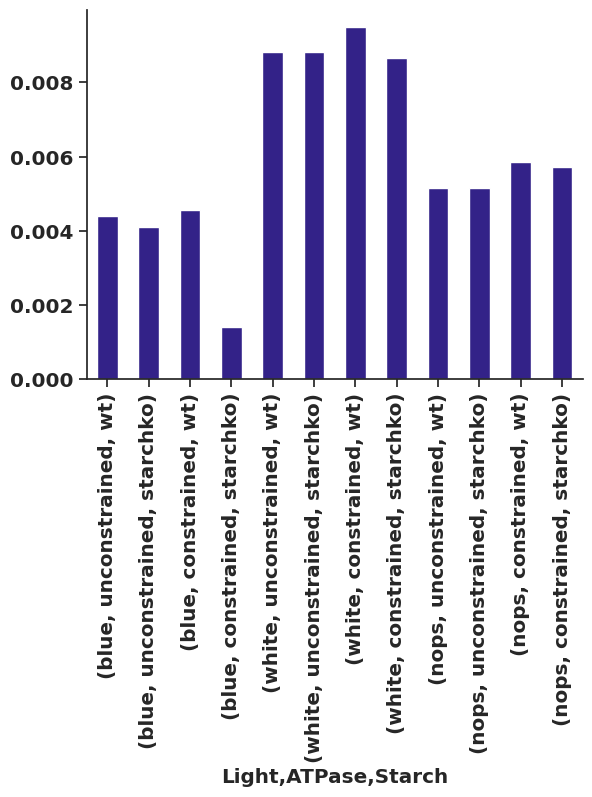

In [105]:
(pm_proton_pump + tonoplast_proton_pump).plot.bar()

In [106]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PHOSGLYPHOS_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000357
       constrained    wt         -0.000476
                      starchko    0.000000
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
nops   unconstrained  wt         -0.000851
                      starchko   -0.000851
       constrained    wt         -0.000563
                      starchko   -0.000932
Name: (PHOSGLYPHOS_RXN_c_gc, 2), dtype: float64

In [107]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("2PGADEHYDRAT_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko   -0.000357
       constrained    wt          0.000435
                      starchko    0.000000
white  unconstrained  wt         -0.001231
                      starchko   -0.001231
       constrained    wt         -0.000643
                      starchko    0.000000
nops   unconstrained  wt          0.000851
                      starchko    0.000851
       constrained    wt          0.000563
                      starchko    0.000932
Name: (2PGADEHYDRAT_RXN_c_gc, 2), dtype: float64

MALATE_DEH_RXN_c_gc## Fraction is ATPase vs PPi for tonoplast

In [108]:
pm_proton_pump / (pm_proton_pump + tonoplast_proton_pump) * 100

Light  ATPase         Starch  
blue   unconstrained  wt          100.000000
                      starchko     93.474071
       constrained    wt          100.000000
                      starchko    100.000000
white  unconstrained  wt            0.000000
                      starchko      0.000000
       constrained    wt            7.356786
                      starchko      0.000000
nops   unconstrained  wt          100.000000
                      starchko    100.000000
       constrained    wt          100.000000
                      starchko    100.000000
dtype: float64

In [109]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 2), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_1339030/2746888614.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                       blue                       \
ATPase                             unconstrained          constrained   
Starch                                        wt starchko          wt   
Reaction                     Phase                                      
PEPDEPHOS_RXN_p_gc           2               0.0      0.0    0.000014   
ATP_ADP_Pi_pc_gc             2               0.0      0.0    0.000000   
PHOSGLYPHOS_RXN_p_gc         2               0.0      0.0    0.000000   
PHOSPHORIBULOKINASE_RXN_p_gc 2               0.0      0.0    0.000000   
6PFRUCTPHOS_RXN_p_gc         2               0.0      0.0    0.000014   
Plastidial_ATP_Synthase_p_gc 2               0.0      0.0    0.000000   

Light                                             white                  nops  \
ATPase                                      constrained           constrained   
Starch                             starchko          wt  starchko          wt   
Reaction                     Phase                                              
PEPDEPHOS_RXN_p_gc           2          0.0    0.000000  0.000000         0.0   
ATP_ADP_Pi_pc_gc             2          0.0    0.001624  0.002154         0.0   
PHOSGLYPHOS_RXN_p_gc         2          0.0    0.018769  0.017978         0.0   
PHOSPHORIBULOKINASE_RXN_p_gc 2          0.0    0.009063  0.009325         0.0   
6PFRUCTPHOS_RXN_p_gc         2          0.0    0.000000  0.000000         0.0   
Plastidial_ATP_Synthase_p_gc 2          0.0    0.009819  0.009819         0.0   

Light                                        
ATPase                                       
Starch                             starchko  
Reaction                     Phase           
PEPDEPHOS_RXN_p_gc           2          0.0  
ATP_ADP_Pi_pc_gc             2          0.0  
PHOSGLYPHOS_RXN_p_gc         2          0.0  
PHOSPHORIBULOKINASE_RXN_p_gc 2          0.0  
6PFRUCTPHOS_RXN_p_gc         2          0.0  
Plastidial_ATP_Synthase_p_gc 2          0.0

In [110]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 3), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_1339030/3411159466.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                       blue                        \
ATPase                             unconstrained           constrained   
Starch                                        wt  starchko          wt   
Reaction                     Phase                                       
GLUC1PADENYLTRANS_RXN_p_gc   3          0.000200  0.000000    0.000773   
PEPDEPHOS_RXN_p_gc           3          0.000000  0.000000    0.000000   
ATP_ADP_Pi_pc_gc             3         -0.000010  0.000166   -0.000507   
PHOSGLYPHOS_RXN_p_gc         3          0.019493  0.019503    0.019453   
PHOSPHORIBULOKINASE_RXN_p_gc 3          0.009773  0.009786    0.009737   
Plastidial_ATP_Synthase_p_gc 3          0.009819  0.009819    0.009819   

Light                                              white            \
ATPase                                       constrained             
Starch                              starchko          wt  starchko   
Reaction                     Phase                                   
GLUC1PADENYLTRANS_RXN_p_gc   3      0.000000    0.000761  0.000000   
PEPDEPHOS_RXN_p_gc           3      0.000000    0.000000  0.000000   
ATP_ADP_Pi_pc_gc             3      0.000312   -0.000493  0.000256   
PHOSGLYPHOS_RXN_p_gc         3      0.019417    0.019450  0.019467   
PHOSPHORIBULOKINASE_RXN_p_gc 3      0.009727    0.009739  0.009733   
Plastidial_ATP_Synthase_p_gc 3      0.009819    0.009819  0.009819   

Light                                     nops           
ATPase                             constrained           
Starch                                      wt starchko  
Reaction                     Phase                       
GLUC1PADENYLTRANS_RXN_p_gc   3        0.000259      0.0  
PEPDEPHOS_RXN_p_gc           3        0.000070      0.0  
ATP_ADP_Pi_pc_gc             3       -0.000165      0.0  
PHOSGLYPHOS_RXN_p_gc         3       -0.000023      0.0  
PHOSPHORIBULOKINASE_RXN_p_gc 3        0.000000      0.0  
Plastidial_ATP_Synthase_p_gc 3        0.000000      0.0

In [111]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_3.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 3), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_1339030/3582217826.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                 blue                                  \
ATPase                       unconstrained           constrained             
Starch                                  wt  starchko          wt  starchko   
Reaction               Phase                                                 
FRUCTOKINASE_RXN_c_gc  3          0.000000  0.000000    0.000000  0.000332   
ATPase_tx_gc           3          0.004690  0.004690    0.004690  0.004690   
ATP_ADP_mc_gc          3          0.005402  0.005322    0.005617  0.005678   
PROTONATP_rev_vc_gc    3          0.000000  0.000000    0.000000  0.000000   
ATP_ADP_Pi_pc_gc       3         -0.000010  0.000166   -0.000507  0.000312   
6PFRUCTPHOS_RXN_c_gc   3          0.000000  0.000000    0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc 3          0.000000  0.000000    0.000000  0.000000   
PEPDEPHOS_RXN_c_gc     3          0.000000  0.000000    0.000000  0.000000   
PROTON_ATPase_c_gc     3          0.000000  0.000000    0.000000  0.000000   
UDPKIN_RXN_c_gc        3          0.000701  0.000798    0.000420  0.000967   
PHOSGLYPHOS_RXN_c_gc   3          0.000000  0.000000    0.000000  0.000000   

Light                              white                  nops            
ATPase                       constrained           constrained            
Starch                                wt  starchko          wt  starchko  
Reaction               Phase                                              
FRUCTOKINASE_RXN_c_gc  3        0.000000  0.000264    0.000328  0.000306  
ATPase_tx_gc           3        0.004690  0.004690    0.000000  0.004690  
ATP_ADP_mc_gc          3        0.005608  0.005641    0.000822  0.004701  
PROTONATP_rev_vc_gc    3        0.000000  0.000000    0.000000  0.000006  
ATP_ADP_Pi_pc_gc       3       -0.000493  0.000256   -0.000165  0.000000  
6PFRUCTPHOS_RXN_c_gc   3        0.000000  0.000000    0.000000  0.000036  
PEPCARBOXYKIN_RXN_c_gc 3        0.000000  0.000000    0.000024  0.000000  
PEPDEPHOS_RXN_c_gc     3        0.000000  0.000000    0.000000  0.000322  
PROTON_ATPase_c_gc     3        0.000000  0.000000    0.000305  0.000286  
UDPKIN_RXN_c_gc        3        0.000424  0.000943    0.000023  0.000020  
PHOSGLYPHOS_RXN_c_gc   3        0.000000  0.000000   -0.000023 -0.000322

In [112]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.NADPH_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 3), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_1339030/2111125671.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
GLU6PDEHYDROG_RXN_p_gc                 3          0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3          0.001854  0.001844   
6PGLUCONDEHYDROG_RXN_p_gc              3          0.000000  0.000000   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3          0.022910  0.022910   
NADPHox_p_tx_gc                        3          0.001563  0.001563   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3          0.019493  0.019503   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
GLU6PDEHYDROG_RXN_p_gc                 3        0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.001894  0.001930   
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000000  0.000000   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.022910  0.022910   
NADPHox_p_tx_gc                        3        0.001563  0.001563   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.019453  0.019417   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
GLU6PDEHYDROG_RXN_p_gc                 3        0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.001897  0.001880   
6PGLUCONDEHYDROG_RXN_p_gc              3        0.000000  0.000000   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.022910  0.022910   
NADPHox_p_tx_gc                        3        0.001563  0.001563   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.019450  0.019467   

Light                                               nops            
ATPase                                       constrained            
Starch                                                wt  starchko  
Reaction                               Phase                        
GLU6PDEHYDROG_RXN_p_gc                 3             0.0  0.000209  
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3             0.0  0.000000  
6PGLUCONDEHYDROG_RXN_p_gc              3             0.0  0.000209  
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3             0.0  0.000000  
NADPHox_p_tx_gc                        3             0.0  0.000418  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3             0.0  0.000000

In [113]:
plastidatp_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.NADH_c_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(plastidatp_reactions, 2), :]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_1339030/1101100446.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                 blue                                 \
ATPase                       unconstrained           constrained            
Starch                                  wt  starchko          wt starchko   
Reaction               Phase                                                
MALATE_DEH_RXN_c_gc    2               0.0  0.000357   -0.000476      0.0   
GAPOXNPHOSPHN_RXN_c_gc 2               0.0 -0.000357    0.000476      0.0   

Light                              white                 nops            
ATPase                       constrained          constrained            
Starch                                wt starchko          wt  starchko  
Reaction               Phase                                             
MALATE_DEH_RXN_c_gc    2             0.0      0.0   -0.000563 -0.000932  
GAPOXNPHOSPHN_RXN_c_gc 2             0.0      0.0    0.000563  0.000932

In [114]:
0.003478 - 0.002659

0.0008190000000000003

In [115]:
0.020457 + 0.010742

0.031198999999999998

In [116]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_ATPase_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.007973
                      starchko    0.008160
       constrained    wt          0.004338
                      starchko    0.004338
white  unconstrained  wt          0.007833
                      starchko    0.007833
       constrained    wt          0.004338
                      starchko    0.004338
nops   unconstrained  wt          0.012386
                      starchko    0.012386
       constrained    wt          0.004338
                      starchko    0.004338
Name: (PROTON_ATPase_c_gc, 2), dtype: float64

In [117]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("MALATE_DEHYDROGENASE_NADPs_RXN_p_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.002897
                      starchko    0.002897
       constrained    wt          0.002577
                      starchko    0.003369
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
Name: (MALATE_DEHYDROGENASE_NADPs_RXN_p_gc, 2), dtype: float64

/tmp/ipykernel_1339030/377450841.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1)


Text(0, 0.5, 'Flux (mmoles$\\cdot$m$^{-2}$$\\cdot$h$^{-1}$)')

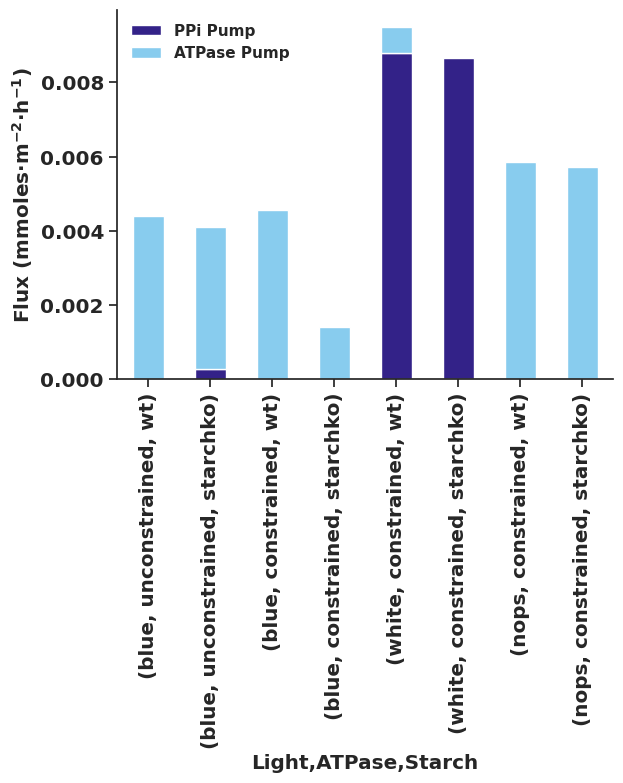

In [118]:
fig, ax = plt.subplots()

tonoplast_proton_transport_df = (
    solutions_df.xs("fluxes", level="Solution", axis=1)
    .loc[(["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :]
    .drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)
)
tonoplast_proton_transport_df.index = ["PPi Pump", "ATPase Pump"]
tonoplast_proton_transport_df.T.plot(kind="bar", stacked=True, ax=ax)

ax.set_ylabel("Flux (mmoles$\cdot$m$^{-2}$$\cdot$h$^{-1}$)")

In [119]:
tonoplast_proton_transport_df

Light                blue                                       white  \
ATPase      unconstrained           constrained           constrained   
Starch                 wt  starchko          wt  starchko          wt   
PPi Pump         0.000000  0.000268    0.000000  0.000000    0.008790   
ATPase Pump      0.004411  0.003839    0.004569  0.001399    0.000698   

Light                        nops            
ATPase                constrained            
Starch       starchko          wt  starchko  
PPi Pump     0.008654    0.000000  0.000000  
ATPase Pump  0.000000    0.005844  0.005713

/tmp/ipykernel_1339030/1652154496.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[(["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :].drop(


<Axes: xlabel='Light,ATPase,Starch'>

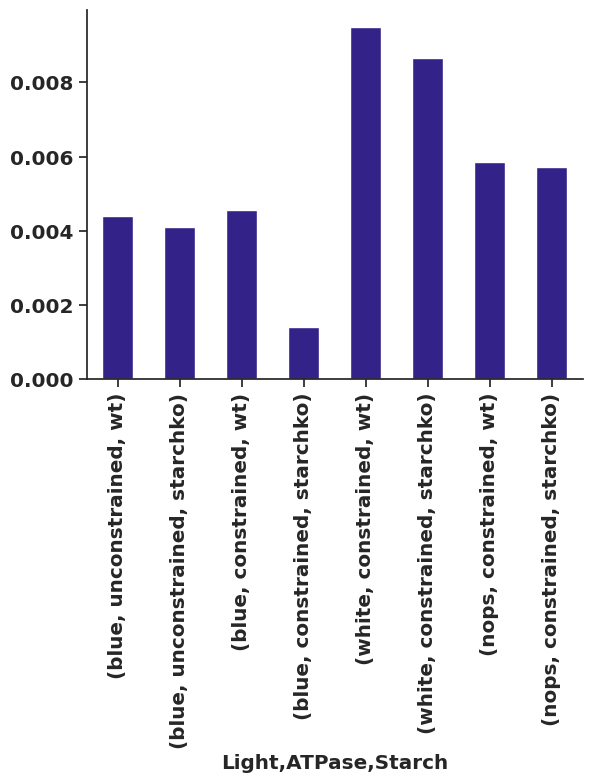

In [120]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[(["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :].drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
).sum().plot.bar()

In [121]:
ppi_reactions = [reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.PPI_c_gc_2.reactions]
ppi_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(ppi_reactions, 2), :]
ppi_df = ppi_df.loc[~(abs(ppi_df) < 0.0000000001).all(axis=1)]
ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)

/tmp/ipykernel_1339030/4224157383.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)


Light                                                   blue            \
ATPase                                         unconstrained             
Starch                                                    wt  starchko   
Reaction                                 Phase                           
PROTON_PPi_rev_vc_gc                     2               0.0  0.000268   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2               0.0  0.000000   
GLUC1PURIDYLTRANS_RXN_c_gc               2               0.0  0.000089   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2               0.0 -0.000179   

Light                                                                \
ATPase                                         constrained            
Starch                                                  wt starchko   
Reaction                                 Phase                        
PROTON_PPi_rev_vc_gc                     2             0.0      0.0   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2             0.0      0.0   
GLUC1PURIDYLTRANS_RXN_c_gc               2             0.0      0.0   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2             0.0      0.0   

Light                                                white            \
ATPase                                         constrained             
Starch                                                  wt  starchko   
Reaction                                 Phase                         
PROTON_PPi_rev_vc_gc                     2        0.008790  0.008654   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2        0.000000  0.000000   
GLUC1PURIDYLTRANS_RXN_c_gc               2        0.000916  0.001219   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2       -0.007874 -0.007435   

Light                                                 nops            
ATPase                                         constrained            
Starch                                                  wt  starchko  
Reaction                                 Phase                        
PROTON_PPi_rev_vc_gc                     2             0.0  0.000000  
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2             0.0  0.000466  
GLUC1PURIDYLTRANS_RXN_c_gc               2             0.0 -0.000466  
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2             0.0  0.000000

In [122]:
ppi_reactions = [reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.PPI_p_gc_2.reactions]
ppi_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(ppi_reactions, 2), :]
ppi_df = ppi_df.loc[~(abs(ppi_df) < 0.0000000001).all(axis=1)]
ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)

/tmp/ipykernel_1339030/1298146970.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)


Empty DataFrame
Columns: [(blue, unconstrained, wt), (blue, unconstrained, starchko), (blue, constrained, wt), (blue, constrained, starchko), (white, constrained, wt), (white, constrained, starchko), (nops, constrained, wt), (nops, constrained, starchko)]
Index: []

In [123]:
boundary_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.reactions if "_tx" in reaction.id
]
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("NITRATE_a_tx", slice(None)), :]
nitrate_uptake

Light                       blue                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.018951  0.018951    0.018951  0.018951   
             2          0.056852  0.056852    0.056852  0.056852   
             3          0.307393  0.307393    0.307393  0.307393   
             4          0.012860  0.012860    0.012860  0.012860   

Light                      white                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.019834  0.019834    0.019834  0.019834   
             2          0.251313  0.251313    0.251312  0.251312   
             3          0.313527  0.313527    0.313527  0.313527   
             4          0.013183  0.013183    0.013183  0.013183   

Light                       nops                                  
ATPase             unconstrained           constrained            
Starch                        wt  starchko          wt  starchko  
Reaction     Phase                                                
NITRATE_a_tx 1          0.019830  0.019830    0.019831  0.019830  
             2          0.251260  0.251260    0.251274  0.251260  
             3          0.313462  0.313462    0.313479  0.313462  
             4          0.013180  0.013180    0.013181  0.013180

In [124]:
from mmon_gcm.analysing import get_phase_lengths

In [125]:
phase_lengths = get_phase_lengths(arabidopsis_supermodel.fba_model)
phase_lengths

[6.0, 0.5, 11.5, 6.0]

In [126]:
for i, phase_length in zip([1, 2, 3, 4], phase_lengths):
    nitrate_uptake.loc[("NITRATE_a_tx", i), :] = nitrate_uptake.loc[("NITRATE_a_tx", i), :] * phase_length
nitrate_uptake

Light                       blue                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.113705  0.113705    0.113705  0.113705   
             2          0.028426  0.028426    0.028426  0.028426   
             3          3.535023  3.535023    3.535021  3.535020   
             4          0.077163  0.077163    0.077163  0.077163   

Light                      white                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.119005  0.119005    0.119005  0.119005   
             2          0.125656  0.125656    0.125656  0.125656   
             3          3.605562  3.605562    3.605561  3.605558   
             4          0.079097  0.079097    0.079097  0.079097   

Light                       nops                                  
ATPase             unconstrained           constrained            
Starch                        wt  starchko          wt  starchko  
Reaction     Phase                                                
NITRATE_a_tx 1          0.118980  0.118980    0.118987  0.118980  
             2          0.125630  0.125630    0.125637  0.125630  
             3          3.604815  3.604815    3.605006  3.604807  
             4          0.079081  0.079081    0.079085  0.079080

In [127]:
nitrate_uptake_day = nitrate_uptake.loc[(slice(None), [2, 3]), :].sum()
nitrate_uptake_night = nitrate_uptake.loc[(slice(None), [1, 4]), :].sum()

In [128]:
nitrate_uptake_day

Light  ATPase         Starch  
blue   unconstrained  wt          3.563449
                      starchko    3.563449
       constrained    wt          3.563448
                      starchko    3.563446
white  unconstrained  wt          3.731218
                      starchko    3.731218
       constrained    wt          3.731217
                      starchko    3.731214
nops   unconstrained  wt          3.730445
                      starchko    3.730445
       constrained    wt          3.730643
                      starchko    3.730437
dtype: float64

In [129]:
nitrate_uptake_night

Light  ATPase         Starch  
blue   unconstrained  wt          0.190868
                      starchko    0.190868
       constrained    wt          0.190868
                      starchko    0.190867
white  unconstrained  wt          0.198102
                      starchko    0.198102
       constrained    wt          0.198102
                      starchko    0.198102
nops   unconstrained  wt          0.198061
                      starchko    0.198061
       constrained    wt          0.198071
                      starchko    0.198060
dtype: float64

In [130]:
nitrate_uptake_day / nitrate_uptake_night

Light  ATPase         Starch  
blue   unconstrained  wt          18.669741
                      starchko    18.669741
       constrained    wt          18.669741
                      starchko    18.669741
white  unconstrained  wt          18.834845
                      starchko    18.834845
       constrained    wt          18.834845
                      starchko    18.834845
nops   unconstrained  wt          18.834845
                      starchko    18.834845
       constrained    wt          18.834845
                      starchko    18.834845
dtype: float64

In [131]:
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("NITRATE_a_Linker", slice(None)), :]
nitrate_uptake

Light                           blue                                \
ATPase                 unconstrained          constrained            
Starch                            wt starchko          wt starchko   
Reaction         Phase                                               
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0   
                 2               0.0      0.0         0.0      0.0   
                 3               0.0      0.0         0.0      0.0   
                 4               0.0      0.0         0.0      0.0   

Light                          white                                \
ATPase                 unconstrained          constrained            
Starch                            wt starchko          wt starchko   
Reaction         Phase                                               
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0   
                 2               0.0      0.0         0.0      0.0   
                 3               0.0      0.0         0.0      0.0   
                 4               0.0      0.0         0.0      0.0   

Light                           nops                                
ATPase                 unconstrained          constrained           
Starch                            wt starchko          wt starchko  
Reaction         Phase                                              
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0  
                 2               0.0      0.0         0.0      0.0  
                 3               0.0      0.0         0.0      0.0  
                 4               0.0      0.0         0.0      0.0

In [132]:
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("NITRATE_ae_me", slice(None)), :]
nitrate_uptake

Light                        blue                                  \
ATPase              unconstrained           constrained             
Starch                         wt  starchko          wt  starchko   
Reaction      Phase                                                 
NITRATE_ae_me 1          0.018951  0.018951    0.018951  0.018951   
              2          0.056852  0.056852    0.056852  0.056852   
              3          0.307393  0.307393    0.307393  0.307393   
              4          0.012860  0.012860    0.012860  0.012860   

Light                       white                                  \
ATPase              unconstrained           constrained             
Starch                         wt  starchko          wt  starchko   
Reaction      Phase                                                 
NITRATE_ae_me 1          0.019834  0.019834    0.019834  0.019834   
              2          0.251313  0.251313    0.251312  0.251312   
              3          0.313527  0.313527    0.313527  0.313527   
              4          0.013183  0.013183    0.013183  0.013183   

Light                        nops                                  
ATPase              unconstrained           constrained            
Starch                         wt  starchko          wt  starchko  
Reaction      Phase                                                
NITRATE_ae_me 1          0.019830  0.019830    0.019831  0.019830  
              2          0.251260  0.251260    0.251274  0.251260  
              3          0.313462  0.313462    0.313479  0.313462  
              4          0.013180  0.013180    0.013181  0.013180

In [133]:
arabidopsis_supermodel.fba_model.metabolites.NITRATE_e_gc_2

Metabolite identifier,NITRATE_e_gc_2
Name,NITRATE_gc_2
Memory address,0x7fb709e869d0
Formula,N1O3
Compartment,e
In 2 reaction(s),"Nitrate_ec_gc_2, NITRATE_ae_gc_2"


In [134]:
filtered_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.NADH_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(filtered_reactions, 2), :]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_1339030/2808846299.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(


Light                                 blue                                 \
ATPase                       unconstrained           constrained            
Starch                                  wt  starchko          wt starchko   
Reaction               Phase                                                
MALATE_DEH_RXN_c_gc    2               0.0  0.000357   -0.000476      0.0   
GAPOXNPHOSPHN_RXN_c_gc 2               0.0 -0.000357    0.000476      0.0   

Light                              white                 nops            
ATPase                       constrained          constrained            
Starch                                wt starchko          wt  starchko  
Reaction               Phase                                             
MALATE_DEH_RXN_c_gc    2             0.0      0.0   -0.000563 -0.000932  
GAPOXNPHOSPHN_RXN_c_gc 2             0.0      0.0    0.000563  0.000932

In [135]:
filtered_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(filtered_reactions, 2), :]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_1339030/3469620016.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(


Light                                                   blue            \
ATPase                                         unconstrained             
Starch                                                    wt  starchko   
Reaction                                 Phase                           
ATPase_tx_gc                             2          0.004690  0.004690   
ATP_ADP_mc_gc                            2          0.017074  0.017493   
ATP_ADP_Pi_pc_gc                         2          0.000000  0.000000   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2          0.000000  0.000000   
6PFRUCTPHOS_RXN_c_gc                     2          0.000000  0.000000   
PROTONATP_rev_vc_gc                      2          0.004411  0.003839   
ATP_AMP_mc_gc                            2          0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc                   2          0.000000  0.000357   
PEPDEPHOS_RXN_c_gc                       2          0.000000  0.000000   
PROTON_ATPase_c_gc                       2          0.007973  0.008160   
UDPKIN_RXN_c_gc                          2          0.000000  0.000089   
PHOSGLYPHOS_RXN_c_gc                     2          0.000000  0.000357   

Light                                                                 \
ATPase                                         constrained             
Starch                                                  wt  starchko   
Reaction                                 Phase                         
ATPase_tx_gc                             2        0.004690  0.004690   
ATP_ADP_mc_gc                            2        0.012877  0.010427   
ATP_ADP_Pi_pc_gc                         2        0.000000  0.000000   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2        0.000000  0.000000   
6PFRUCTPHOS_RXN_c_gc                     2        0.000218  0.000000   
PROTONATP_rev_vc_gc                      2        0.004569  0.001399   
ATP_AMP_mc_gc                            2        0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc                   2        0.000000  0.000000   
PEPDEPHOS_RXN_c_gc                       2        0.000462  0.000000   
PROTON_ATPase_c_gc                       2        0.004338  0.004338   
UDPKIN_RXN_c_gc                          2        0.000000  0.000000   
PHOSGLYPHOS_RXN_c_gc                     2       -0.000476  0.000000   

Light                                                white            \
ATPase                                         constrained             
Starch                                                  wt  starchko   
Reaction                                 Phase                         
ATPase_tx_gc                             2        0.004690  0.004690   
ATP_ADP_mc_gc                            2        0.009663  0.008094   
ATP_ADP_Pi_pc_gc                         2        0.001624  0.002154   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2        0.000000  0.000000   
6PFRUCTPHOS_RXN_c_gc                     2        0.000000  0.000000   
PROTONATP_rev_vc_gc                      2        0.000698  0.000000   
ATP_AMP_mc_gc                            2        0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc                   2        0.000643  0.000000   
PEPDEPHOS_RXN_c_gc                       2        0.000000  0.000000   
PROTON_ATPase_c_gc                       2        0.004338  0.004338   
UDPKIN_RXN_c_gc                          2        0.000916  0.001219   
PHOSGLYPHOS_RXN_c_gc                     2        0.000000  0.000000   

Light                                                 nops            
ATPase                                         constrained            
Starch                                                  wt  starchko  
Reaction                                 Phase                        
ATPase_tx_gc                             2        0.000000  0.004690  
ATP_ADP_mc_gc                            2        0.009901  0.013343  
ATP_ADP_Pi_pc_gc                         2        0.000000  0.000000  
PYRUVATEORTH

In [136]:
filtered_reactions = [
    reaction.id[:-2] for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(filtered_reactions, 2), :]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).loc[:, ("white", "constrained", "wt")]

Reaction                                  Phase
ATPase_tx_gc                              2        0.004690
ATP_ADP_mc_gc                             2        0.009663
ATP_ADP_Pi_pc_gc                          2        0.001624
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc  2        0.000000
6PFRUCTPHOS_RXN_c_gc                      2        0.000000
PROTONATP_rev_vc_gc                       2        0.000698
ATP_AMP_mc_gc                             2        0.000000
PEPCARBOXYKIN_RXN_c_gc                    2        0.000643
PEPDEPHOS_RXN_c_gc                        2        0.000000
PROTON_ATPase_c_gc                        2        0.004338
UDPKIN_RXN_c_gc                           2        0.000916
PHOSGLYPHOS_RXN_c_gc                      2        0.000000
Name: (white, constrained, wt), dtype: float64

In [137]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(
    [("white", "unconstrained"), ("nops", "unconstrained")]
)

/tmp/ipykernel_1339030/42660494.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(


Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000357
       constrained    wt          0.000000
                      starchko    0.000000
white  constrained    wt          0.000643
                      starchko    0.000000
nops   constrained    wt          0.000000
                      starchko    0.000000
Name: (PEPCARBOXYKIN_RXN_c_gc, 2), dtype: float64

In [138]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(
    [("white", "unconstrained"), ("nops", "unconstrained")]
)

/tmp/ipykernel_1339030/42660494.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PEPCARBOXYKIN_RXN_c_gc", 2), :].drop(


Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000357
       constrained    wt          0.000000
                      starchko    0.000000
white  constrained    wt          0.000643
                      starchko    0.000000
nops   constrained    wt          0.000000
                      starchko    0.000000
Name: (PEPCARBOXYKIN_RXN_c_gc, 2), dtype: float64

In [139]:
phloem_outputs = solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Phloem_tx_overall", np.nan), :]

In [140]:
phloem_outputs

Light  ATPase         Starch  
blue   unconstrained  wt          15.179236
                      starchko    15.179235
       constrained    wt          15.179230
                      starchko    15.179223
white  unconstrained  wt          15.886800
                      starchko    15.886800
       constrained    wt          15.886793
                      starchko    15.886784
nops   unconstrained  wt          15.883507
                      starchko    15.883507
       constrained    wt          15.884351
                      starchko    15.883475
Name: (Phloem_tx_overall, nan), dtype: float64

In [141]:
phloem_outputs_dict = {}
for name, value in phloem_outputs.items():
    phloem_outputs_dict[name] = (phloem_outputs / value * 100).round(3)

In [142]:
phloem_outputs_comparison_table = pd.DataFrame.from_dict(phloem_outputs_dict)
phloem_outputs_comparison_table.to_csv("../outputs/efficiency_comparisons/phloem_outputs_compare.csv")
phloem_outputs_comparison_table

blue                                \
                             unconstrained          constrained            
                                        wt starchko          wt starchko   
Light ATPase        Starch                                                 
blue  unconstrained wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
      constrained   wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
white unconstrained wt             104.661  104.661     104.661  104.661   
                    starchko       104.661  104.661     104.661  104.661   
      constrained   wt             104.661  104.661     104.661  104.661   
                    starchko       104.661  104.661     104.661  104.661   
nops  unconstrained wt             104.640  104.640     104.640  104.640   
                    starchko       104.640  104.640     104.640  104.640   
      constrained   wt             104.645  104.645     104.645  104.645   
                    starchko       104.639  104.639     104.640  104.640   

                                     white                                \
                             unconstrained          constrained            
                                        wt starchko          wt starchko   
Light ATPase        Starch                                                 
blue  unconstrained wt              95.546   95.546      95.546   95.546   
                    starchko        95.546   95.546      95.546   95.546   
      constrained   wt              95.546   95.546      95.546   95.546   
                    starchko        95.546   95.546      95.546   95.546   
white unconstrained wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
      constrained   wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
nops  unconstrained wt              99.979   99.979      99.979   99.979   
                    starchko        99.979   99.979      99.979   99.979   
      constrained   wt              99.985   99.985      99.985   99.985   
                    starchko        99.979   99.979      99.979   99.979   

                                      nops                                
                             unconstrained          constrained           
                                        wt starchko          wt starchko  
Light ATPase        Starch                                                
blue  unconstrained wt              95.566   95.566      95.561   95.566  
                    starchko        95.566   95.566      95.561   95.566  
      constrained   wt              95.566   95.566      95.561   95.566  
                    starchko        95.566   95.566      95.561   95.566  
white unconstrained wt             100.021  100.021     100.015  100.021  
                    starchko       100.021  100.021     100.015  100.021  
      constrained   wt             100.021  100.021     100.015  100.021  
                    starchko       100.021  100.021     100.015  100.021  
nops  unconstrained wt             100.000  100.000      99.995  100.000  
                    starchko       100.000  100.000      99.995  100.000  
      constrained   wt             100.005  100.005     100.000  100.006  
                    starchko       100.000  100.000      99.994  100.000

In [143]:
100 - 99.980

0.01999999999999602

In [144]:
phloem_outputs_blue = phloem_outputs.loc["blue"]
phloem_outputs_blue / phloem_outputs_blue.iloc[0] * 100

ATPase         Starch  
unconstrained  wt          100.000000
               starchko     99.999998
constrained    wt           99.999961
               starchko     99.999916
Name: (Phloem_tx_overall, nan), dtype: float64

In [145]:
phloem_outputs_white = phloem_outputs.drop("blue")
phloem_outputs_white = phloem_outputs_white / phloem_outputs_white.iloc[0] * 100
phloem_outputs_white

/tmp/ipykernel_1339030/3118140255.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  phloem_outputs_white = phloem_outputs.drop("blue")


Light  ATPase         Starch  
white  unconstrained  wt          100.000000
                      starchko     99.999998
       constrained    wt           99.999956
                      starchko     99.999894
nops   unconstrained  wt           99.979272
                      starchko     99.979272
       constrained    wt           99.984581
                      starchko     99.979069
Name: (Phloem_tx_overall, nan), dtype: float64

In [146]:
phloem_outputs.drop("blue")

/tmp/ipykernel_1339030/4124221444.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  phloem_outputs.drop("blue")


Light  ATPase         Starch  
white  unconstrained  wt          15.886800
                      starchko    15.886800
       constrained    wt          15.886793
                      starchko    15.886784
nops   unconstrained  wt          15.883507
                      starchko    15.883507
       constrained    wt          15.884351
                      starchko    15.883475
Name: (Phloem_tx_overall, nan), dtype: float64

<Axes: xlabel='Light,ATPase,Starch'>

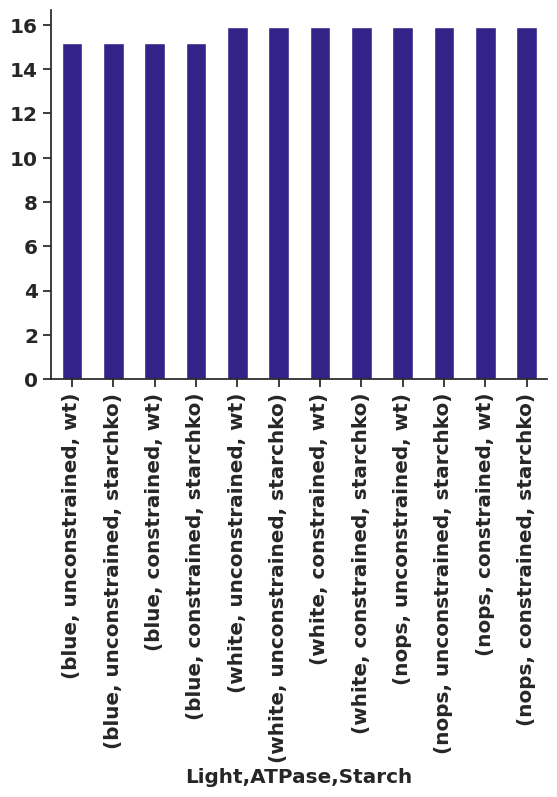

In [147]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Phloem_tx_overall", np.nan), :].plot.bar()

In [148]:
arabidopsis_supermodel.get_prop_gc()

0.0030263085626407423

In [149]:
5.17 * arabidopsis_supermodel.get_prop_gc() * 0.3

0.004693804580655791